In [1]:
import pandas as pd
import re
import numpy as np
import gspread
from gspread_dataframe import get_as_dataframe
from oauth2client.service_account import ServiceAccountCredentials
#from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from Deals import deals_df
from scipy.stats import norm

In [2]:
# Просмотр загруженного датафрейма
print(deals_df.head())

                    Id Deal Owner Name Closing Date            Quality  \
0  5805028000056864695        Ben Hall          NaT                NaN   
1  5805028000056859489   Ulysses Adams          NaT                NaN   
2  5805028000056832357   Ulysses Adams   2024-06-21     D - Non Target   
3  5805028000056824246        Eva Kent   2024-06-21  E - Non Qualified   
4  5805028000056873292        Ben Hall   2024-06-21     D - Non Target   

      Stage     Lost Reason       Page                  Campaign       SLA  \
0  New Lead             NaN  /eng/test             03.07.23women       NaN   
1  New Lead             NaN    /at-eng                       NaN       NaN   
2      Lost      Non target    /at-eng                engwien_AT  00:26:43   
3      Lost  Invalid number       /eng  04.07.23recentlymoved_DE  01:00:04   
4      Lost      Non target       /eng              discovery_DE  00:53:12   

                   Ad  ...        Product Education Type        Created Time  \
0     

In [3]:
# Приведение всех значений к строковому типу
deals_df['Level of Deutsch'] = deals_df['Level of Deutsch'].astype(str)

# Замена NaN на маркер, если требуется
deals_df['Level of Deutsch'] = deals_df['Level of Deutsch'].replace('nan', '-1')

# Функция для классификации уровня с использованием регулярных выражений
def classify_level(text):
    text = text.lower()
    
    if re.search(r'\b(гражданка|гражданин|c1|c2|с1|с2)\b', text):
        return 'C'
    
    if re.search(r'\b(b2|b\+|b2\+|b1|b1\+|b1-б2|b1-|б1|б2|б1-б2|б2-)\b', text):
        return 'B'
    
    if re.search(r'\b(a2|a1|a0|a\+|а2|а1|а0|а1-а2|a0-a1)\b', text):
        return 'A'
    
    return 'Неизвестно'

# Применяем функцию к столбцу
deals_df['Category Deutsch'] = deals_df['Level of Deutsch'].apply(classify_level)

# Просмотр результата
print(deals_df[['Level of Deutsch', 'Category Deutsch']])

      Level of Deutsch Category Deutsch
0                   -1       Неизвестно
1                   -1       Неизвестно
2                   -1       Неизвестно
3                   -1       Неизвестно
4                   -1       Неизвестно
...                ...              ...
21586               -1       Неизвестно
21587               -1       Неизвестно
21588               -1       Неизвестно
21589               -1       Неизвестно
21590               -1       Неизвестно

[21502 rows x 2 columns]


In [4]:
deals_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21502 entries, 0 to 21590
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id                   21502 non-null  Int64         
 1   Deal Owner Name      21502 non-null  object        
 2   Closing Date         14597 non-null  datetime64[ns]
 3   Quality              19250 non-null  object        
 4   Stage                21502 non-null  object        
 5   Lost Reason          16071 non-null  object        
 6   Page                 21502 non-null  object        
 7   Campaign             16031 non-null  object        
 8   SLA                  15463 non-null  object        
 9   Ad                   14119 non-null  object        
 10  AdGroup              12426 non-null  object        
 11  Source               21502 non-null  object        
 12  Payment Type         491 non-null    object        
 13  Product              3566 non-null  

In [5]:
#удаляем столбцы, потому что они мне не нужны для анализа.
columns_to_drop_deals = ['Level of Deutsch', 'Initial Amount Paid']
deals_df.drop(columns=columns_to_drop_deals, axis = 1 , inplace=True)
deals_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21502 entries, 0 to 21590
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Id                  21502 non-null  Int64         
 1   Deal Owner Name     21502 non-null  object        
 2   Closing Date        14597 non-null  datetime64[ns]
 3   Quality             19250 non-null  object        
 4   Stage               21502 non-null  object        
 5   Lost Reason         16071 non-null  object        
 6   Page                21502 non-null  object        
 7   Campaign            16031 non-null  object        
 8   SLA                 15463 non-null  object        
 9   Ad                  14119 non-null  object        
 10  AdGroup             12426 non-null  object        
 11  Source              21502 non-null  object        
 12  Payment Type        491 non-null    object        
 13  Product             3566 non-null   object        


Процент пропущенных значений по каждому столбцу:
Id                     0.000000
Deal Owner Name        0.000000
Closing Date          32.113292
Quality               10.473444
Stage                  0.000000
Lost Reason           25.258116
Page                   0.000000
Campaign              25.444145
SLA                   28.085759
Ad                    34.336341
AdGroup               42.210027
Source                 0.000000
Payment Type          97.716491
Product               83.415496
Education Type        84.764208
Created Time           0.000000
Course duration       83.438750
Months of study       96.130593
Offer Total Amount    80.713422
CONTACTID              0.000000
City                  88.396428
Category Deutsch       0.000000
dtype: float64


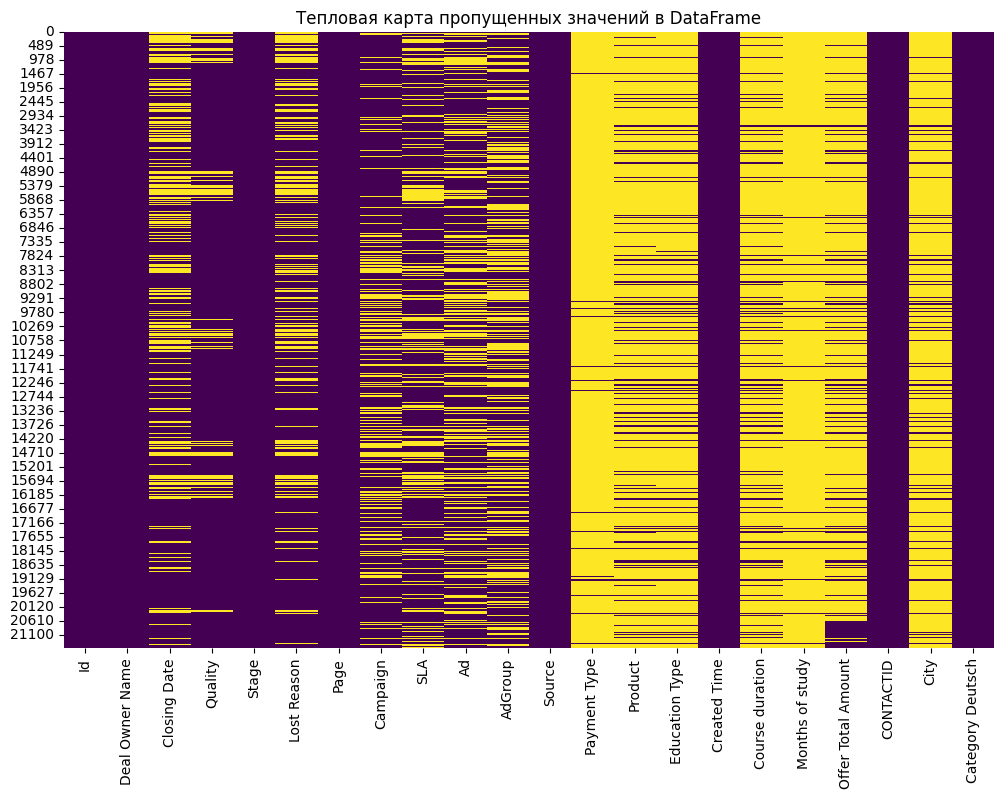

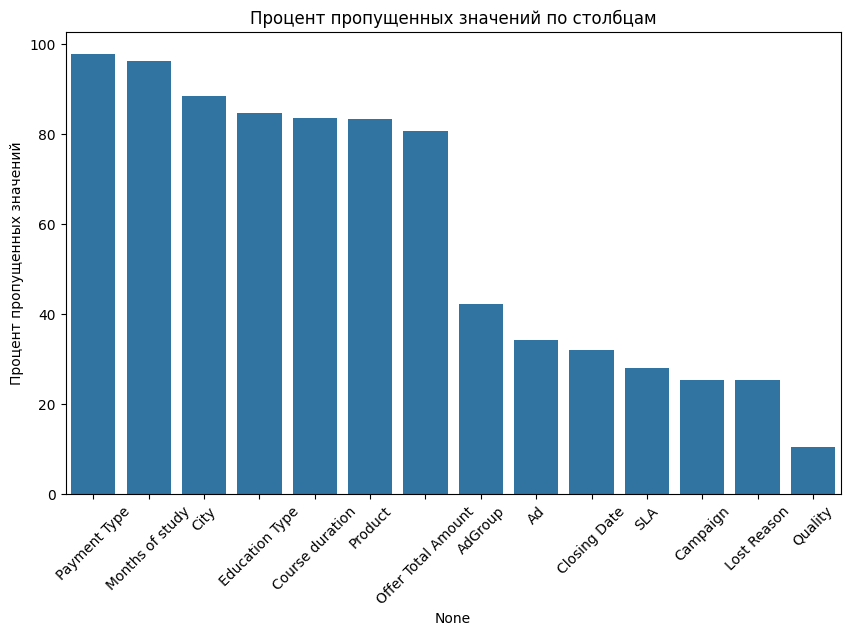

In [6]:
# Отображение пропущенных значений в процентах для каждого столбца
missing_data = deals_df.isnull().mean() * 100
print("Процент пропущенных значений по каждому столбцу:")
print(missing_data)

# Визуализация пропущенных данных с использованием тепловой карты (heatmap)
plt.figure(figsize=(12, 8))
sns.heatmap(deals_df.isnull(), cbar=False, cmap='viridis')
plt.title('Тепловая карта пропущенных значений в DataFrame')
plt.show()

# Гистограмма пропущенных данных по столбцам
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_data.index, y=missing_data)
plt.title('Процент пропущенных значений по столбцам')
plt.ylabel('Процент пропущенных значений')
plt.xticks(rotation=45)
plt.show()

In [7]:
#запускаем ячейку и заполняем пропущенные значения в столбце Closing Date

# Проверка на наличие пропущенных значений в 'Closing Date'
print("Пропущенные значения в 'Closing Date':", deals_df['Closing Date'].isna().sum())

# Предобработка данных
deals_df['Created Time'] = pd.to_datetime(deals_df['Created Time']).astype('int64') // 10**9  # Преобразование в Unix время
print("Created Time после преобразования в Unix время:\n", deals_df['Created Time'])

# Преобразование 'Closing Date' в Unix время, оставляя NaT как NaN
deals_df['Closing Date'] = deals_df['Closing Date'].apply(lambda x: x.timestamp() if pd.notnull(x) else np.nan)
print("Closing Date после преобразования в Unix время:\n", deals_df['Closing Date'])

# Кодирование категориальных переменных
label_encoder_owner = LabelEncoder()
deals_df['Deal Owner Name Encoded'] = label_encoder_owner.fit_transform(deals_df['Deal Owner Name'])

# Разделение данных на обучающую и тестовую выборки
train_df = deals_df.dropna(subset=['Closing Date'])
test_df = deals_df[deals_df['Closing Date'].isna()]

# Проверка размеров обучающего и тестового наборов данных
print("Размер обучающего набора данных:", train_df.shape)
print("Размер тестового набора данных:", test_df.shape)

if not test_df.empty:
    X = train_df[['Deal Owner Name Encoded', 'CONTACTID', 'Created Time']]
    y = train_df['Closing Date']

    # Разделение на обучающую и тестовую выборки для оценки метрик
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Обучение модели
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Предсказание на валидационной выборке
    y_val_pred = model.predict(X_val)

    # Подсчет метрик
    mae = mean_absolute_error(y_val, y_val_pred)
    mse = mean_squared_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)

    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'R-squared (R²): {r2:.4f}')

    # Предсказание пропущенных значений
    X_test = test_df[['Deal Owner Name Encoded', 'CONTACTID', 'Created Time']]
    predictions = model.predict(X_test)

    # Заполнение пропущенных значений в исходном DataFrame
    deals_df.loc[deals_df['Closing Date'].isna(), 'Closing Date'] = predictions

    # Преобразование обратно в формат datetime
    deals_df['Closing Date'] = pd.to_datetime(deals_df['Closing Date'], unit='s')
else:
    print("Нет данных для предсказания.")

# Декодирование обратно имен владельцев сделок
deals_df['Deal Owner Name'] = label_encoder_owner.inverse_transform(deals_df['Deal Owner Name Encoded'])
deals_df['Created Time'] = pd.to_datetime(deals_df['Created Time'], unit='s')

# Просмотр обновленного DataFrame
print(deals_df[['Id', 'Deal Owner Name', 'CONTACTID', 'Created Time', 'Closing Date', 'Quality']])

Пропущенные значения в 'Closing Date': 6905
Created Time после преобразования в Unix время:
 0        1718983800
1        1718983380
2        1718981100
3        1718976720
4        1718976060
            ...    
21586    1688465460
21587    1688463240
21588    1688454600
21589    1688454600
21590    1688416740
Name: Created Time, Length: 21502, dtype: int64
Closing Date после преобразования в Unix время:
 0                 NaN
1                 NaN
2        1.718928e+09
3        1.718928e+09
4        1.718928e+09
             ...     
21586             NaN
21587    1.688602e+09
21588    1.688429e+09
21589    1.693267e+09
21590    1.693267e+09
Name: Closing Date, Length: 21502, dtype: float64
Размер обучающего набора данных: (14597, 23)
Размер тестового набора данных: (6905, 23)
Mean Absolute Error (MAE): 1535572.6789
Mean Squared Error (MSE): 8824936267653.1309
R-squared (R²): 0.8612
                        Id Deal Owner Name            CONTACTID  \
0      5805028000056864695        B

In [8]:
#заполняем Education после Closing Date

#заполняем Education Type  машинным обучением с проверкой метрик - это правильный код!!!! Но есть сообщения от системы 

# Предобработка данных
deals_df['Created Time'] = pd.to_datetime(deals_df['Created Time']).astype('int64') // 10**9  # Преобразование в Unix время
deals_df['Closing Date'] = pd.to_datetime(deals_df['Closing Date'], errors='coerce').astype('int64') // 10**9  # Преобразование в Unix время

# Кодирование категориальных переменных
label_encoder_owner = LabelEncoder()
deals_df['Deal Owner Name Encoded'] = label_encoder_owner.fit_transform(deals_df['Deal Owner Name'])

# Кодирование целевой переменной (Product)
label_encoder_quality = LabelEncoder()
deals_df['Education Type_Encoded'] = label_encoder_quality.fit_transform(deals_df['Education Type'].astype(str))

# Разделение данных на обучающую и тестовую выборки
train_df = deals_df.dropna(subset=['Education Type'])
test_df = deals_df[deals_df['Education Type'].isna()]

# Проверка размеров обучающего и тестового наборов данных
print("Размер обучающего набора данных:", train_df.shape)
print("Размер тестового набора данных:", test_df.shape)

if not test_df.empty:
    X = train_df[['Deal Owner Name Encoded', 'CONTACTID', 'Created Time', 'Closing Date']]
    y = train_df['Education Type_Encoded']

    # Разделение данных на обучающую и тестовую выборки
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Обучение модели
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Предсказание на валидационных данных
    y_pred = model.predict(X_val)

    # Вычисление метрик
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Предсказание пропущенных значений
    X_test = test_df[['Deal Owner Name Encoded', 'CONTACTID', 'Created Time', 'Closing Date']]
    predictions = model.predict(X_test)

    # Заполнение пропущенных значений в исходном DataFrame
    deals_df.loc[deals_df['Education Type'].isna(), 'Education Type_Encoded'] = predictions

    # Преобразование обратно в категории
    deals_df['Education Type'] = label_encoder_quality.inverse_transform(deals_df['Education Type_Encoded'].astype(int))
else:
    print("Нет данных для предсказания.")

# Декодирование обратно имен владельцев сделок
deals_df['Deal Owner Name'] = label_encoder_owner.inverse_transform(deals_df['Deal Owner Name Encoded'])
deals_df['Created Time'] = pd.to_datetime(deals_df['Created Time'], unit='s')
deals_df['Closing Date'] = pd.to_datetime(deals_df['Closing Date'], unit='s')

# Просмотр обновленного DataFrame
print(deals_df[['Id', 'Deal Owner Name', 'CONTACTID', 'Created Time', 'Closing Date', 'Education Type']])

Размер обучающего набора данных: (3276, 24)
Размер тестового набора данных: (18226, 24)
Accuracy: 0.8567
Precision: 0.8068
Recall: 0.8567
F1 Score: 0.8236
                        Id Deal Owner Name            CONTACTID  \
0      5805028000056864695        Ben Hall  5805028000056849495   
1      5805028000056859489   Ulysses Adams  5805028000056834471   
2      5805028000056832357   Ulysses Adams  5805028000056854421   
3      5805028000056824246        Eva Kent  5805028000056889351   
4      5805028000056873292        Ben Hall  5805028000056876176   
...                    ...             ...                  ...   
21586  5805028000000947046   Oliver Taylor  5805028000000939010   
21587  5805028000000935025    Kevin Parker  5805028000000983028   
21588  5805028000000970006      Jane Smith  5805028000000979006   
21589  5805028000000948010      Jane Smith  5805028000000979006   
21590  5805028000000945016      Jane Smith  5805028000000968001   

             Created Time        Closing

In [9]:
#заполняем Course duration  машинным обучением с проверкой метрик - это правильный код!!!! Но есть сообщения от системы 

# Предобработка данных
deals_df['Created Time'] = pd.to_datetime(deals_df['Created Time']).astype('int64') // 10**9  # Преобразование в Unix время
deals_df['Closing Date'] = pd.to_datetime(deals_df['Closing Date'], errors='coerce').astype('int64') // 10**9  # Преобразование в Unix время

# Кодирование категориальных переменных
#label_encoder_owner = LabelEncoder()
#deals_df['Deal Owner Name Encoded'] = label_encoder_owner.fit_transform(deals_df['Deal Owner Name'])

# Кодирование целевой переменной (Course duration)
label_encoder_duration = LabelEncoder()
deals_df['Course duration_Encoded'] = label_encoder_duration.fit_transform(deals_df['Course duration'].astype(str))

# Разделение данных на обучающую и тестовую выборки
train_df = deals_df.dropna(subset=['Course duration'])
test_df = deals_df[deals_df['Course duration'].isna()]

# Проверка размеров обучающего и тестового наборов данных
print("Размер обучающего набора данных:", train_df.shape)
print("Размер тестового набора данных:", test_df.shape)

if not test_df.empty:
    X = train_df[['Created Time', 'Closing Date']]
    y = train_df['Course duration_Encoded']

    # Разделение данных на обучающую и тестовую выборки
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Обучение модели
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Предсказание на валидационных данных
    y_pred = model.predict(X_val)

    # Вычисление метрик
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Предсказание пропущенных значений
    X_test = test_df[['Created Time', 'Closing Date']]
    predictions = model.predict(X_test)

    # Заполнение пропущенных значений в исходном DataFrame
    deals_df.loc[deals_df['Course duration'].isna(), 'Course duration_Encoded'] = predictions

    # Преобразование обратно в категории
    deals_df['Course duration'] = label_encoder_duration.inverse_transform(deals_df['Course duration_Encoded'].astype(int))
else:
    print("Нет данных для предсказания.")

# Декодирование обратно имен владельцев сделок
#deals_df['Deal Owner Name'] = label_encoder_owner.inverse_transform(deals_df['Deal Owner Name Encoded'])
deals_df['Created Time'] = pd.to_datetime(deals_df['Created Time'], unit='s')
deals_df['Closing Date'] = pd.to_datetime(deals_df['Closing Date'], unit='s')

# Просмотр обновленного DataFrame
print(deals_df[['Id','Created Time', 'Closing Date', 'Course duration']])

Размер обучающего набора данных: (3561, 25)
Размер тестового набора данных: (17941, 25)
Accuracy: 0.7728
Precision: 0.7232
Recall: 0.7728
F1 Score: 0.7432
                        Id        Created Time        Closing Date  \
0      5805028000056864695 2024-06-21 15:30:00 2024-06-20 23:45:36   
1      5805028000056859489 2024-06-21 15:23:00 2024-06-21 00:00:00   
2      5805028000056832357 2024-06-21 14:45:00 2024-06-21 00:00:00   
3      5805028000056824246 2024-06-21 13:32:00 2024-06-21 00:00:00   
4      5805028000056873292 2024-06-21 13:21:00 2024-06-21 00:00:00   
...                    ...                 ...                 ...   
21586  5805028000000947046 2023-07-04 10:11:00 2023-10-07 23:31:12   
21587  5805028000000935025 2023-07-04 09:34:00 2023-07-06 00:00:00   
21588  5805028000000970006 2023-07-04 07:10:00 2023-07-04 00:00:00   
21589  5805028000000948010 2023-07-04 07:10:00 2023-08-29 00:00:00   
21590  5805028000000945016 2023-07-03 20:39:00 2023-08-29 00:00:00   

    

In [10]:
deals_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21502 entries, 0 to 21590
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Id                       21502 non-null  Int64         
 1   Deal Owner Name          21502 non-null  object        
 2   Closing Date             21502 non-null  datetime64[ns]
 3   Quality                  19250 non-null  object        
 4   Stage                    21502 non-null  object        
 5   Lost Reason              16071 non-null  object        
 6   Page                     21502 non-null  object        
 7   Campaign                 16031 non-null  object        
 8   SLA                      15463 non-null  object        
 9   Ad                       14119 non-null  object        
 10  AdGroup                  12426 non-null  object        
 11  Source                   21502 non-null  object        
 12  Payment Type             491 non-null

In [11]:
#Product ЗАПУСКАЕМ с метрикамии после него запускаем Quality

#заполняем столбец Product машинным обучением, проверяем метрики, и качество модели.

# Предобработка данных
deals_df['Created Time'] = pd.to_datetime(deals_df['Created Time']).astype('int64') // 10**9  # Преобразование в Unix время
deals_df['Closing Date'] = pd.to_numeric(deals_df['Closing Date'], errors='coerce') // 10**9  # Преобразование в Unix время

# Кодирование категориальных переменных
label_encoder_education = LabelEncoder()
deals_df['Education Type Encoded'] = label_encoder_education.fit_transform(deals_df['Education Type'].astype(str))

label_encoder_duration = LabelEncoder()
deals_df['Course duration Encoded'] = label_encoder_duration.fit_transform(deals_df['Course duration'].astype(str))

# Кодирование целевой переменной (Product)
label_encoder_product = LabelEncoder()
deals_df['Product_Encoded'] = label_encoder_product.fit_transform(deals_df['Product'].astype(str))

# Разделение данных на обучающую и тестовую выборки
train_df = deals_df.dropna(subset=['Product'])
test_df = deals_df[deals_df['Product'].isna()]

# Проверка размеров обучающего и тестового наборов данных
print("Размер обучающего набора данных:", train_df.shape)
print("Размер тестового набора данных:", test_df.shape)

if not test_df.empty:
    X = train_df[['Closing Date', 'Education Type Encoded', 'Course duration Encoded']]
    y = train_df['Product_Encoded']

    # Разделение на обучающую и тестовую выборки для оценки метрик
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Обучение модели
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Предсказание на валидационной выборке
    y_val_pred = model.predict(X_val)

    # Подсчет метрик
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f'Accuracy: {accuracy:.4f}')
    print('Отчет о классификации:')
    print(classification_report(y_val, y_val_pred))

    # Предсказание пропущенных значений
    X_test = test_df[['Closing Date', 'Education Type Encoded', 'Course duration Encoded']]
    predictions = model.predict(X_test)

    # Заполнение пропущенных значений в исходном DataFrame
    deals_df.loc[deals_df['Product'].isna(), 'Product_Encoded'] = predictions

    # Преобразование обратно в категории
    deals_df['Product'] = label_encoder_product.inverse_transform(deals_df['Product_Encoded'].astype(int))
else:
    print("Нет данных для предсказания.")

# Преобразование обратно в человеческие-readable форматы
deals_df['Created Time'] = pd.to_datetime(deals_df['Created Time'], unit='s')
deals_df['Closing Date'] = pd.to_datetime(deals_df['Closing Date'], unit='s')


# Просмотр обновленного DataFrame
print(deals_df[['Id', 'Product']])

Размер обучающего набора данных: (3566, 28)
Размер тестового набора данных: (17936, 28)
Accuracy: 0.6499
Отчет о классификации:
              precision    recall  f1-score   support

           1       0.67      0.71      0.69       392
           2       0.00      0.00      0.00         1
           3       0.35      0.31      0.33       197
           4       1.00      1.00      1.00       124

    accuracy                           0.65       714
   macro avg       0.51      0.51      0.51       714
weighted avg       0.64      0.65      0.64       714

                        Id            Product
0      5805028000056864695      Web Developer
1      5805028000056859489      Web Developer
2      5805028000056832357      Web Developer
3      5805028000056824246      Web Developer
4      5805028000056873292      Web Developer
...                    ...                ...
21586  5805028000000947046  Digital Marketing
21587  5805028000000935025  Digital Marketing
21588  5805028000000970

In [12]:
#ЗАПОЛНЕНИЕ СТОЛБЦА Category Deutsch через Deal Owner Name Encoded', 'CONTACTID', 'Created Time', 'Closing Date'
# по этим данным результат обучения лучше

# Преобразование дат в Unix время
deals_df['Created Time'] = pd.to_datetime(deals_df['Created Time'], errors='coerce').astype('int64') // 10**9
deals_df['Closing Date'] = pd.to_datetime(deals_df['Closing Date'], errors='coerce').astype('int64') // 10**9

# Кодирование категориальных переменных
label_encoder_owner = LabelEncoder()
deals_df['Deal Owner Name Encoded'] = label_encoder_owner.fit_transform(deals_df['Deal Owner Name'].astype(str))

# Кодирование целевой переменной
label_encoder_quality = LabelEncoder()
deals_df['Category Deutsch_Encoded'] = label_encoder_quality.fit_transform(deals_df['Category Deutsch'].astype(str))

# Разделение данных на обучающую и тестовую выборки
train_df = deals_df[deals_df['Category Deutsch'] != 'Неизвестно']
test_df = deals_df[deals_df['Category Deutsch'] == 'Неизвестно']

# Проверка размеров обучающего и тестового наборов данных
print("Размер обучающего набора данных:", train_df.shape)
print("Размер тестового набора данных:", test_df.shape)

if not test_df.empty:
    # Разделение обучающего набора данных на тренировочную и валидационную выборки
    X = train_df[['Deal Owner Name Encoded', 'CONTACTID', 'Created Time', 'Closing Date']]
    y = train_df['Category Deutsch_Encoded']
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Обучение модели
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Предсказание на валидационной выборке
    y_val_pred = model.predict(X_val)

    # Подсчет метрик
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f'Accuracy: {accuracy:.4f}')
    
    print('Отчет о классификации:')
    print(classification_report(y_val, y_val_pred))

    # Предсказание пропущенных значений в тестовом наборе
    X_test = test_df[['Deal Owner Name Encoded', 'CONTACTID', 'Created Time', 'Closing Date']]
    predictions = model.predict(X_test)

    # Заполнение пропущенных значений в исходном DataFrame
    deals_df.loc[deals_df['Category Deutsch'] == 'Неизвестно', 'Category Deutsch_Encoded'] = predictions

    # Преобразование обратно в категории
    deals_df['Category Deutsch'] = label_encoder_quality.inverse_transform(deals_df['Category Deutsch_Encoded'].astype(int))
else:
    print("Нет данных для предсказания.")

# Восстановление исходных значений дат
deals_df['Created Time'] = pd.to_datetime(deals_df['Created Time'], unit='s', errors='coerce')
deals_df['Closing Date'] = pd.to_datetime(deals_df['Closing Date'], unit='s', errors='coerce')

# Декодирование обратно имен владельцев сделок
deals_df['Deal Owner Name'] = label_encoder_owner.inverse_transform(deals_df['Deal Owner Name Encoded'])

# Просмотр обновленного DataFrame
print(deals_df[['Id', 'Deal Owner Name', 'CONTACTID', 'Created Time', 'Closing Date', 'Category Deutsch']])

Размер обучающего набора данных: (943, 29)
Размер тестового набора данных: (20559, 29)
Accuracy: 0.8254
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.33      0.26      0.29        23
           1       0.88      0.94      0.91       158
           2       0.50      0.12      0.20         8

    accuracy                           0.83       189
   macro avg       0.57      0.44      0.47       189
weighted avg       0.80      0.83      0.81       189

                        Id Deal Owner Name            CONTACTID  \
0      5805028000056864695        Ben Hall  5805028000056849495   
1      5805028000056859489   Ulysses Adams  5805028000056834471   
2      5805028000056832357   Ulysses Adams  5805028000056854421   
3      5805028000056824246        Eva Kent  5805028000056889351   
4      5805028000056873292        Ben Hall  5805028000056876176   
...                    ...             ...                  ...   
21586  5805028000000947

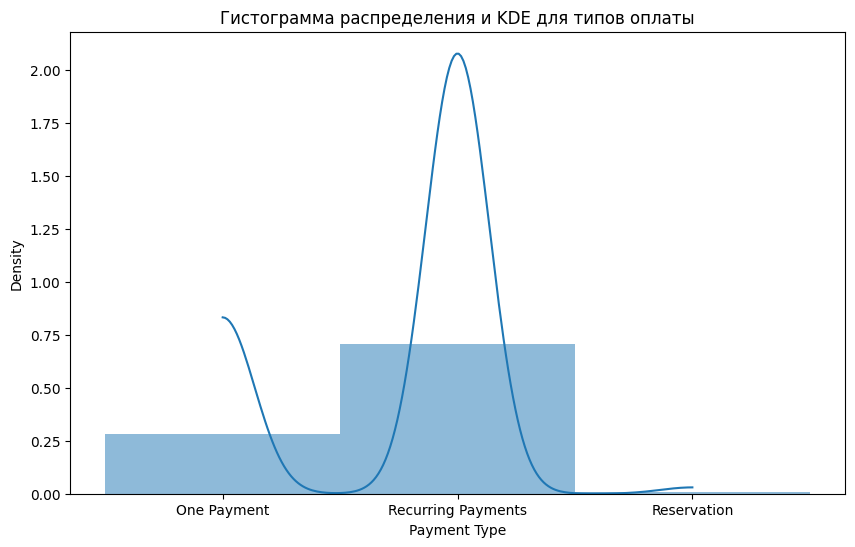

Среднее (μ) по Payment Type: 0.3333333333333333
Стандартное отклонение (σ) по Payment Type: 0.35097585017873467
0
                        Id Deal Owner Name City            Product  \
0      5805028000056864695        Ben Hall  NaN      Web Developer   
1      5805028000056859489   Ulysses Adams  NaN      Web Developer   
2      5805028000056832357   Ulysses Adams  NaN      Web Developer   
3      5805028000056824246        Eva Kent  NaN      Web Developer   
4      5805028000056873292        Ben Hall  NaN      Web Developer   
...                    ...             ...  ...                ...   
21586  5805028000000947046   Oliver Taylor  NaN  Digital Marketing   
21587  5805028000000935025    Kevin Parker  NaN  Digital Marketing   
21588  5805028000000970006      Jane Smith  NaN  Digital Marketing   
21589  5805028000000948010      Jane Smith  NaN  Digital Marketing   
21590  5805028000000945016      Jane Smith  NaN  Digital Marketing   

      Education Type            Quality      

In [13]:
# Фильтрация данных, чтобы рассматривать только строки с заполненными значениями в столбце Payment Type
filled_payment_types = deals_df['Payment Type'].dropna()

# Построение гистограммы распределения и KDE
plt.figure(figsize=(10, 6))
sns.histplot(filled_payment_types, kde=True, stat="density", linewidth=0)
plt.title('Гистограмма распределения и KDE для типов оплаты')
plt.xlabel('Payment Type')
plt.ylabel('Density')

# Определение среднего (μ) и стандартного отклонения (σ)
payment_type_counts = filled_payment_types.value_counts()
payment_type_probs = payment_type_counts / payment_type_counts.sum()
mean_payment_type = payment_type_probs.mean()
std_payment_type = payment_type_probs.std()

# Показать график
plt.show()

# Вывод значений среднего и стандартного отклонения
print(f"Среднее (μ) по Payment Type: {mean_payment_type}")
print(f"Стандартное отклонение (σ) по Payment Type: {std_payment_type}")

# Заполнение пропущенных значений в столбце Payment Type
deals_df['Payment Type'] = deals_df['Payment Type'].apply(
    lambda x: np.random.choice(payment_type_counts.index, p=payment_type_probs) if pd.isna(x) else x
)

# Проверка, что все пропущенные значения заполнены
print(deals_df['Payment Type'].isna().sum())

# Просмотр обновленного DataFrame
print(deals_df[['Id', 'Deal Owner Name', 'City', 'Product', 'Education Type', 'Quality', 'Payment Type']])

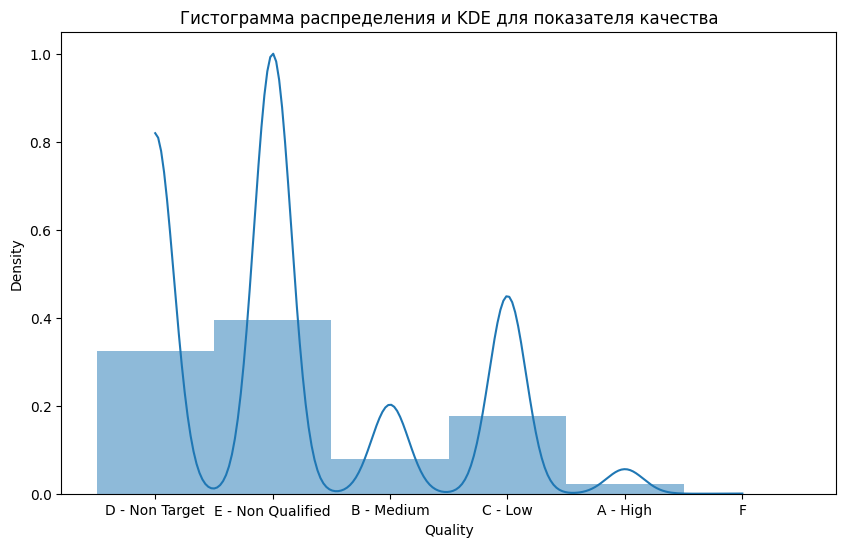

Среднее (μ) по Quality: 0.16666666666666666
Стандартное отклонение (σ) по Quality: 0.1634077237275975
0
                        Id Deal Owner Name City            Product  \
0      5805028000056864695        Ben Hall  NaN      Web Developer   
1      5805028000056859489   Ulysses Adams  NaN      Web Developer   
2      5805028000056832357   Ulysses Adams  NaN      Web Developer   
3      5805028000056824246        Eva Kent  NaN      Web Developer   
4      5805028000056873292        Ben Hall  NaN      Web Developer   
...                    ...             ...  ...                ...   
21586  5805028000000947046   Oliver Taylor  NaN  Digital Marketing   
21587  5805028000000935025    Kevin Parker  NaN  Digital Marketing   
21588  5805028000000970006      Jane Smith  NaN  Digital Marketing   
21589  5805028000000948010      Jane Smith  NaN  Digital Marketing   
21590  5805028000000945016      Jane Smith  NaN  Digital Marketing   

      Education Type            Quality        Payment 

In [14]:
# Фильтрация данных, чтобы рассматривать только строки с заполненными значениями в столбце Quality
filled_quality = deals_df['Quality'].dropna()

# Построение гистограммы распределения и KDE
plt.figure(figsize=(10, 6))
sns.histplot(filled_quality, kde=True, stat="density", linewidth=0)
plt.title('Гистограмма распределения и KDE для показателя качества')
plt.xlabel('Quality')
plt.ylabel('Density')

# Определение среднего (μ) и стандартного отклонения (σ)
quality_counts = filled_quality.value_counts()
quality_probs = quality_counts / quality_counts.sum()
mean_quality = quality_probs.mean()
std_quality = quality_probs.std()

# Показать график
plt.show()

# Вывод значений среднего и стандартного отклонения
print(f"Среднее (μ) по Quality: {mean_quality}")
print(f"Стандартное отклонение (σ) по Quality: {std_quality}")

# Заполнение пропущенных значений в столбце Quality
deals_df['Quality'] = deals_df['Quality'].apply(
    lambda x: np.random.choice(quality_counts.index, p=quality_probs) if pd.isna(x) else x
)

# Проверка, что все пропущенные значения заполнены
print(deals_df['Quality'].isna().sum())

# Просмотр обновленного DataFrame
print(deals_df[['Id', 'Deal Owner Name', 'City', 'Product', 'Education Type', 'Quality', 'Payment Type']])


In [15]:
#заполняем Offer Total Amount  машинным обучением с проверкой метрик - это правильный код!!!! Но есть сообщения от системы 

# Предобработка данных
deals_df['Created Time'] = pd.to_datetime(deals_df['Created Time']).astype('int64') // 10**9  # Преобразование в Unix время
deals_df['Closing Date'] = pd.to_datetime(deals_df['Closing Date'], errors='coerce').astype('int64') // 10**9  # Преобразование в Unix время

# Кодирование категориальных переменных
label_encoder_owner = LabelEncoder()
deals_df['Deal Owner Name Encoded'] = label_encoder_owner.fit_transform(deals_df['Deal Owner Name'])

# Кодирование целевой переменной (Product)
label_encoder_quality = LabelEncoder()
deals_df['Offer Total Amount_Encoded'] = label_encoder_quality.fit_transform(deals_df['Offer Total Amount'].astype(str))

# Разделение данных на обучающую и тестовую выборки
train_df = deals_df.dropna(subset=['Offer Total Amount'])
test_df = deals_df[deals_df['Offer Total Amount'].isna()]

# Проверка размеров обучающего и тестового наборов данных
print("Размер обучающего набора данных:", train_df.shape)
print("Размер тестового набора данных:", test_df.shape)

if not test_df.empty:
    X = train_df[['Deal Owner Name Encoded', 'CONTACTID', 'Created Time', 'Closing Date']]
    y = train_df['Offer Total Amount_Encoded']

    # Разделение данных на обучающую и тестовую выборки
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Обучение модели
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
    model.fit(X_train, y_train)

    # Предсказание на валидационных данных
    y_pred = model.predict(X_val)

    # Вычисление метрик
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Предсказание пропущенных значений
    X_test = test_df[['Deal Owner Name Encoded', 'CONTACTID', 'Created Time', 'Closing Date']]
    predictions = model.predict(X_test)

    # Заполнение пропущенных значений в исходном DataFrame
    deals_df.loc[deals_df['Offer Total Amount'].isna(), 'Offer Total Amount_Encoded'] = predictions

    # Преобразование обратно в категории
    deals_df['Offer Total Amount'] = label_encoder_quality.inverse_transform(deals_df['Offer Total Amount_Encoded'].astype(int))
else:
    print("Нет данных для предсказания.")

# Декодирование обратно имен владельцев сделок
deals_df['Deal Owner Name'] = label_encoder_owner.inverse_transform(deals_df['Deal Owner Name Encoded'])
deals_df['Created Time'] = pd.to_datetime(deals_df['Created Time'], unit='s')
deals_df['Closing Date'] = pd.to_datetime(deals_df['Closing Date'], unit='s')

# Просмотр обновленного DataFrame
print(deals_df[['Id', 'Deal Owner Name', 'CONTACTID', 'Created Time', 'Closing Date', 'Offer Total Amount']])

Размер обучающего набора данных: (4147, 30)
Размер тестового набора данных: (17355, 30)


C:\Users\ICH\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ICH\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.6169
Precision: 0.5386
Recall: 0.6169
F1 Score: 0.5664
                        Id Deal Owner Name            CONTACTID  \
0      5805028000056864695        Ben Hall  5805028000056849495   
1      5805028000056859489   Ulysses Adams  5805028000056834471   
2      5805028000056832357   Ulysses Adams  5805028000056854421   
3      5805028000056824246        Eva Kent  5805028000056889351   
4      5805028000056873292        Ben Hall  5805028000056876176   
...                    ...             ...                  ...   
21586  5805028000000947046   Oliver Taylor  5805028000000939010   
21587  5805028000000935025    Kevin Parker  5805028000000983028   
21588  5805028000000970006      Jane Smith  5805028000000979006   
21589  5805028000000948010      Jane Smith  5805028000000979006   
21590  5805028000000945016      Jane Smith  5805028000000968001   

             Created Time        Closing Date Offer Total Amount  
0     2024-06-21 15:30:00 2024-06-20 23:45:36             900

In [13]:
deals_df = pd.DataFrame(deals_df.copy())

In [15]:
deals_df.City.nunique()

872

In [16]:
city_counts = deals_df['City'].value_counts(dropna=False)
print(city_counts)

City
NaN                  19007
nan                    345
Berlin                 182
München                 74
Hamburg                 62
                     ...  
Weinähr                  1
Wiefelstede              1
Fritzlar                 1
Rheda-Wiedenbrück        1
Brake                    1
Name: count, Length: 873, dtype: int64


In [18]:
deals_df.City.unique()

array(['München', 'Dortmund', 'Thüringen', 'Kassel', 'Berlin',
       'Crailsheim', 'Stuttgart', 'Gummersbach', 'Dillenburg',
       'Offenbach am Main', 'Wien', 'Eberbach', 'Görlitz', 'Pfedelbach',
       'Wenzenbach', 'Dresden', 'Unterhaching', 'Pommelsbrunn',
       'Duisburg', 'Düren', 'Rüdesheim am Rhein', 'Schiltach',
       'Burghausen', 'Leinfelden-Echterdingen', 'Gommern', 'Merseburg',
       'Podskalie', 'Schwandorf', 'Herzogenrath', 'Mainz',
       'Mönchengladbach', 'Neu-Ulm', 'Zinnowitz', 'Quedlinburg',
       'Rosenheim', 'Wolfsburg', 'Gdansk', 'Weilburg', 'Leipzig',
       'Schwarzenberg', 'Bad Oeynhausen', 'Laubach',
       'Lutherstadt Wittenberg', 'Lauter-Bernsbach', 'Riedstadt', 'Bonn',
       'Neuburg', 'Chemnitz', 'Düsseldorf', 'Rostock', 'Bremen',
       'Zwickau', 'Nuenchritz', 'Diez', 'Rheine', 'Halle', 'Nürnberg',
       'Arnsberg', 'Kiel', 'Magdeburg', 'Erbach', 'Leonberg', 'Jünkerath',
       'Hof', 'Theres', 'Murr', 'Germering', 'Hamburg', 'Bochum',
       '

In [17]:
# Заменяем строковые 'nan' на настоящие NaN
deals_df['City'] = deals_df['City'].replace('nan', pd.NA)

city_counts = deals_df['City'].value_counts(dropna=False)
print(city_counts)



City
NaN                  19007
<NA>                   345
Berlin                 182
München                 74
Hamburg                 62
                     ...  
Weinähr                  1
Wiefelstede              1
Fritzlar                 1
Rheda-Wiedenbrück        1
Brake                    1
Name: count, Length: 873, dtype: int64


In [18]:
# Определение моды по столбцу City
city_mode = deals_df['City'].mode().iloc[0]
print(f"Мода по столбцу City: {city_mode}")


Мода по столбцу City: Berlin


In [ ]:
# Заполнение пропущенных значений модой
#deals_df['City'].fillna(city_mode, inplace=True)

# Просмотр обновленного DataFrame
#print(deals_df[['City']])

In [19]:

# Получение списка городов с количеством их повторений
city_counts = deals_df['City'].value_counts(dropna=False)

# Вывод списка городов и количества их повторений
print(city_counts)

City
NaN                  19007
<NA>                   345
Berlin                 182
München                 74
Hamburg                 62
                     ...  
Weinähr                  1
Wiefelstede              1
Fritzlar                 1
Rheda-Wiedenbrück        1
Brake                    1
Name: count, Length: 873, dtype: int64


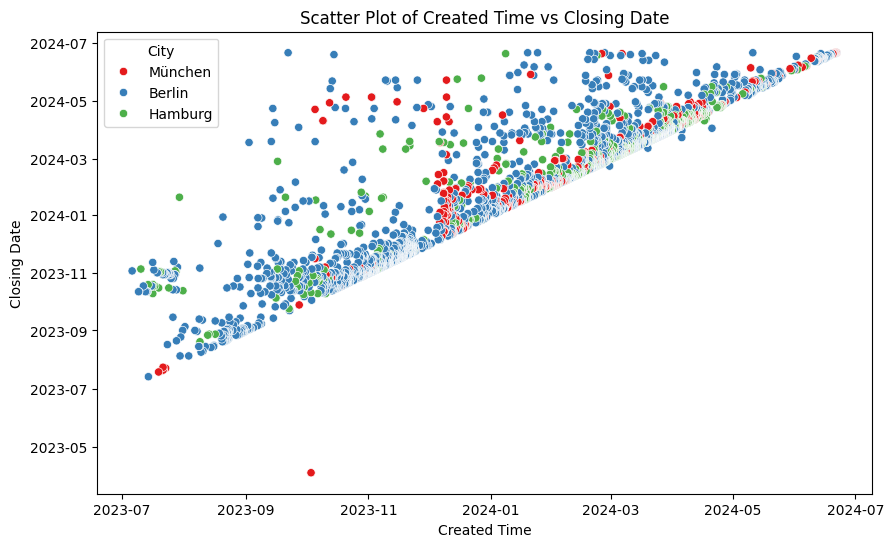

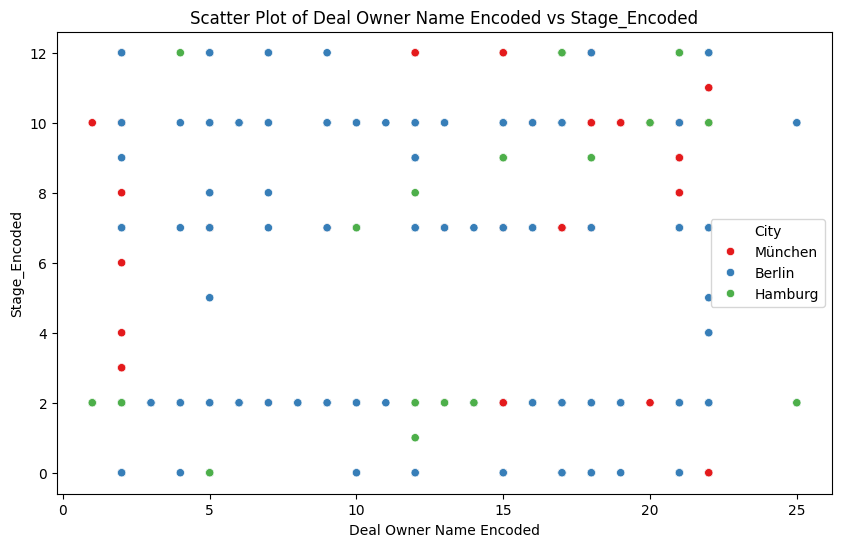

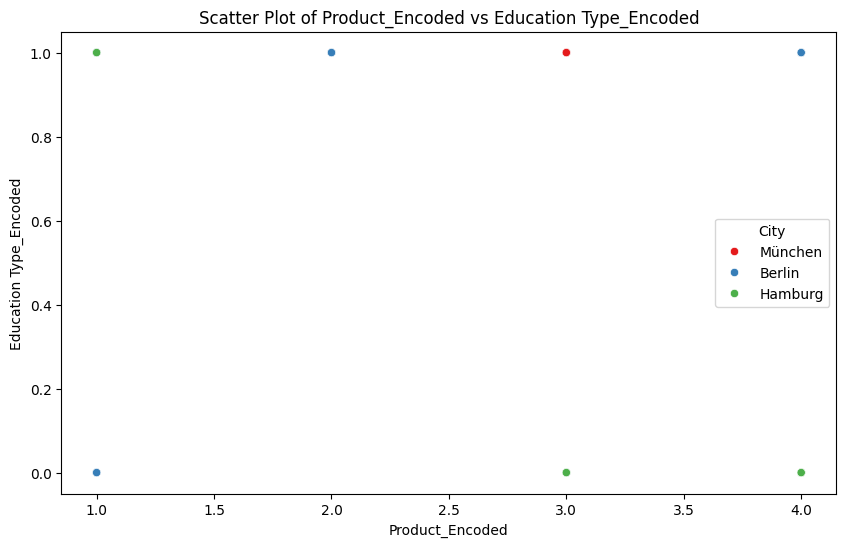

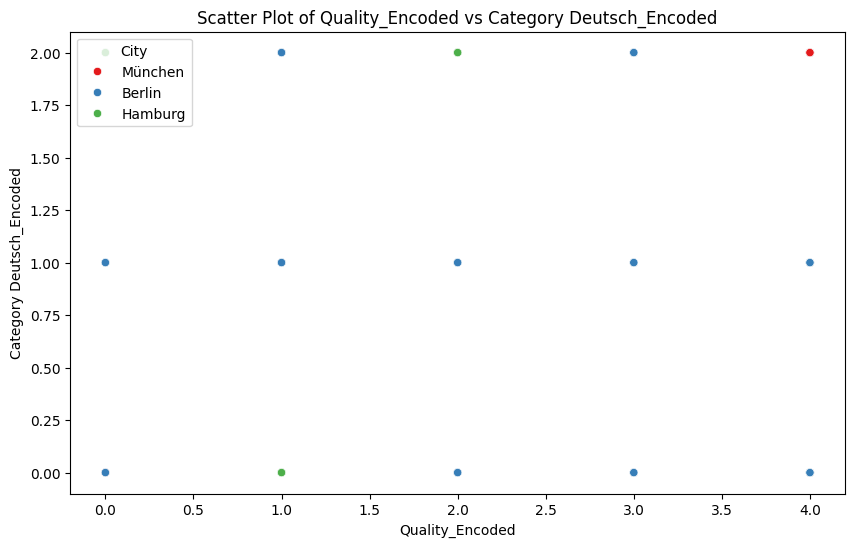

In [21]:
# Отфильтруем данные для Берлин, Мюнхен и Гамбург
filtered_deals_df = deals_df[deals_df['City'].isin(['Berlin', 'München', 'Hamburg'])]

# Пары признаков для построения скаттерплотов
feature_pairs = [
    ('Created Time', 'Closing Date'),
    ('Deal Owner Name Encoded', 'Stage_Encoded'),
    ('Product_Encoded', 'Education Type_Encoded'),
    ('Quality_Encoded', 'Category Deutsch_Encoded')
    
]

# Построение скаттерплотов
for (feature1, feature2) in feature_pairs:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=filtered_deals_df, x=feature1, y=feature2, hue='City', palette='Set1')
    plt.title(f'Scatter Plot of {feature1} vs {feature2}')
    plt.show()

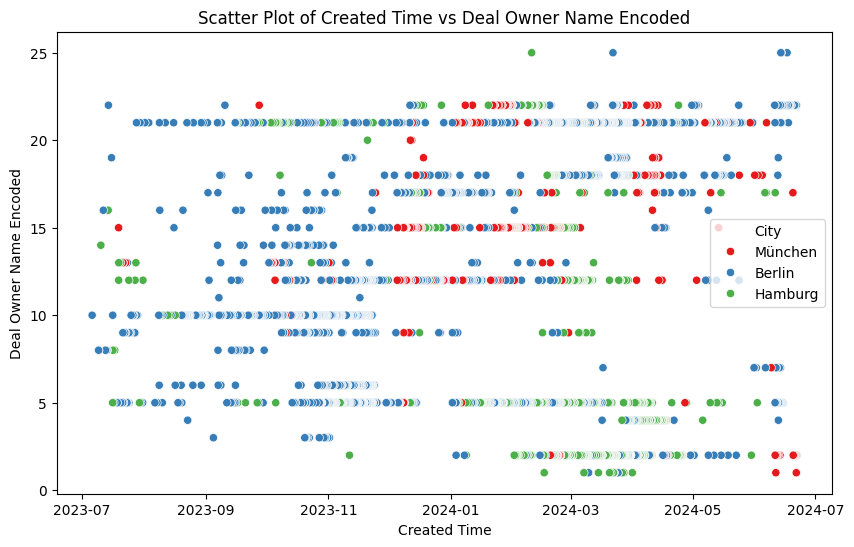

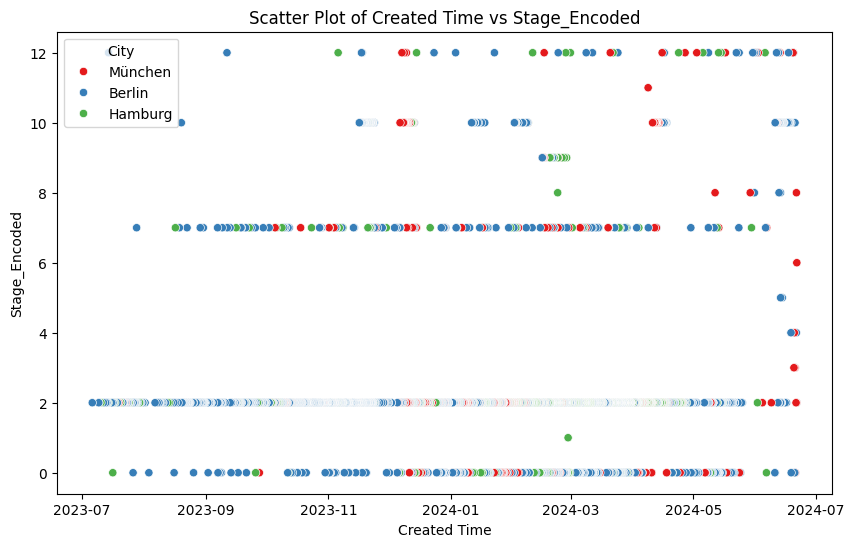

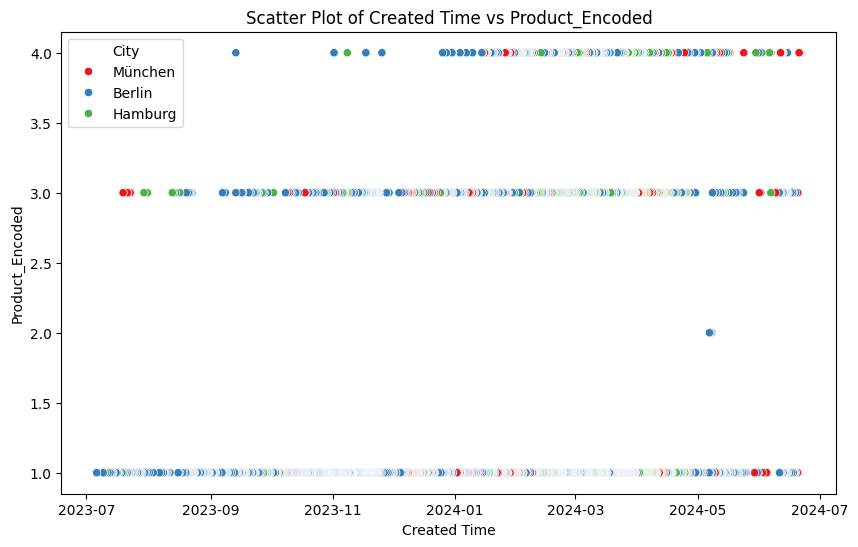

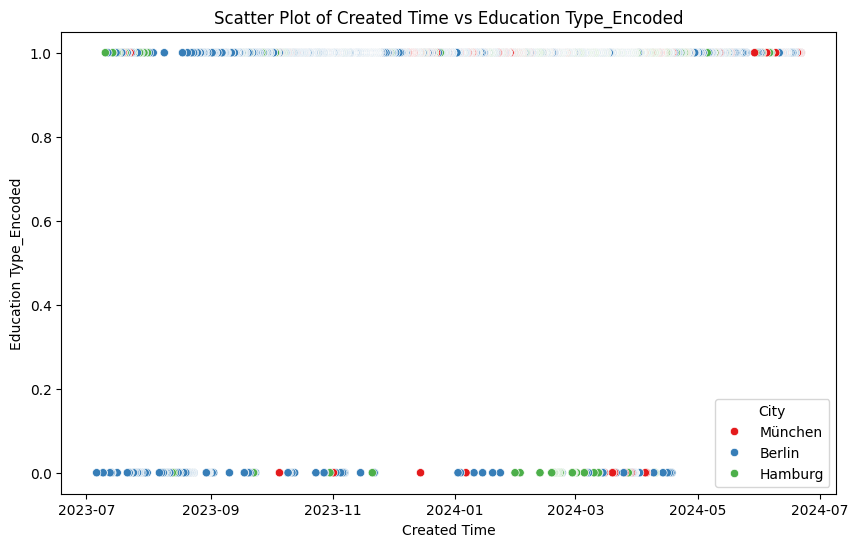

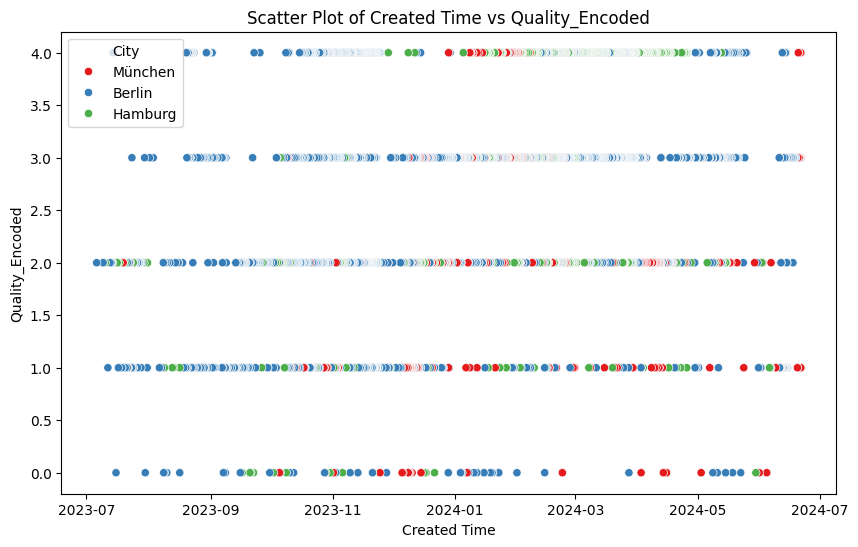

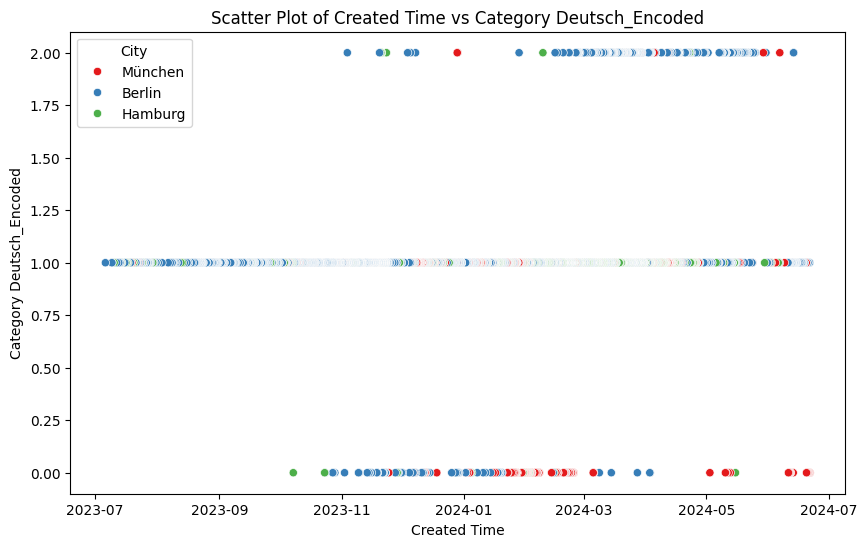

In [24]:
# Отфильтруем данные для Берлин, Мюнхен и Гамбург
filtered_deals_df = deals_df[deals_df['City'].isin(['Berlin', 'München', 'Hamburg'])]

# Пары признаков для построения скаттерплотов
feature_pairs = [
    
    ('Created Time', 'Deal Owner Name Encoded'),
    ('Created Time', 'Stage_Encoded' ),
    ('Created Time', 'Product_Encoded'),
    ('Created Time', 'Education Type_Encoded'),
    ('Created Time', 'Quality_Encoded'),
    ('Created Time', 'Category Deutsch_Encoded')
]

# Построение скаттерплотов
for (feature1, feature2) in feature_pairs:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=filtered_deals_df, x=feature1, y=feature2, hue='City', palette='Set1')
    plt.title(f'Scatter Plot of {feature1} vs {feature2}')
    plt.show()

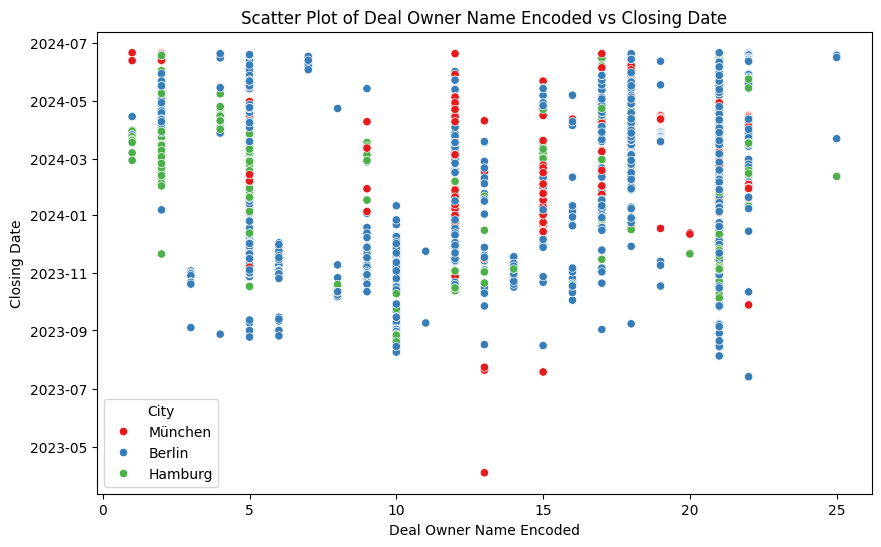

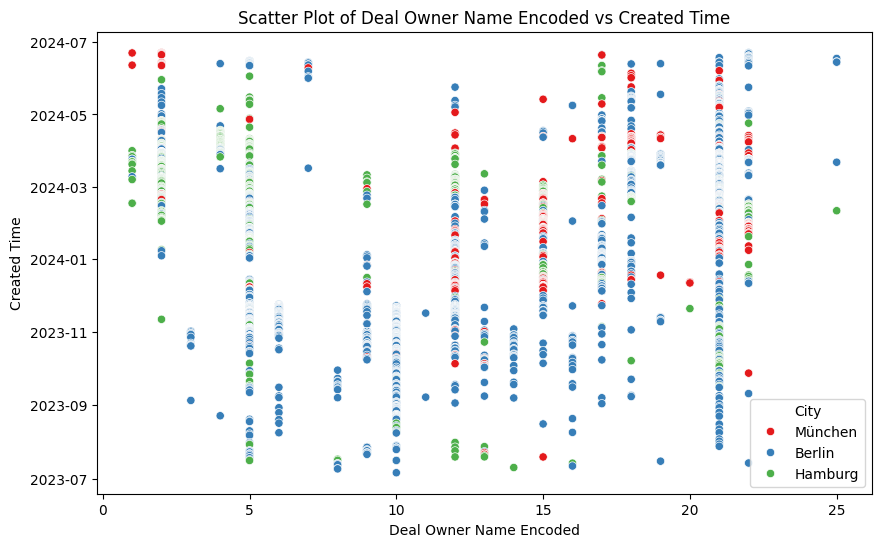

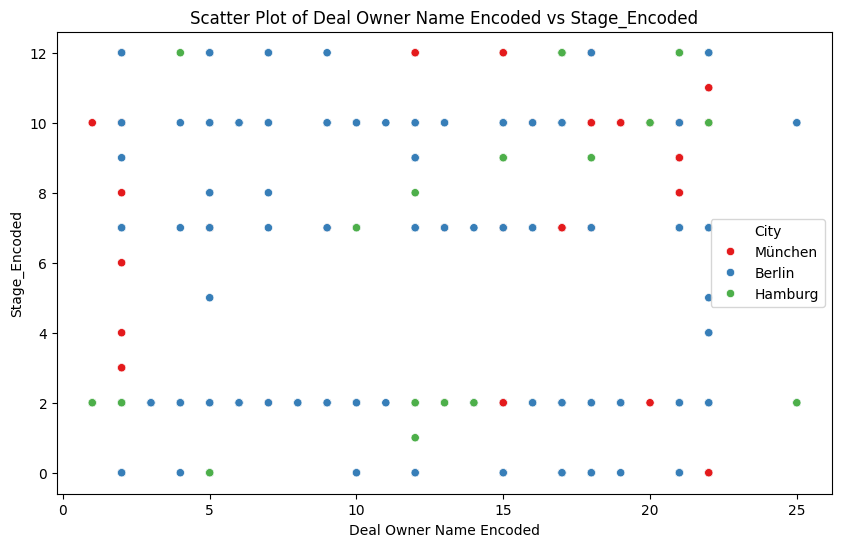

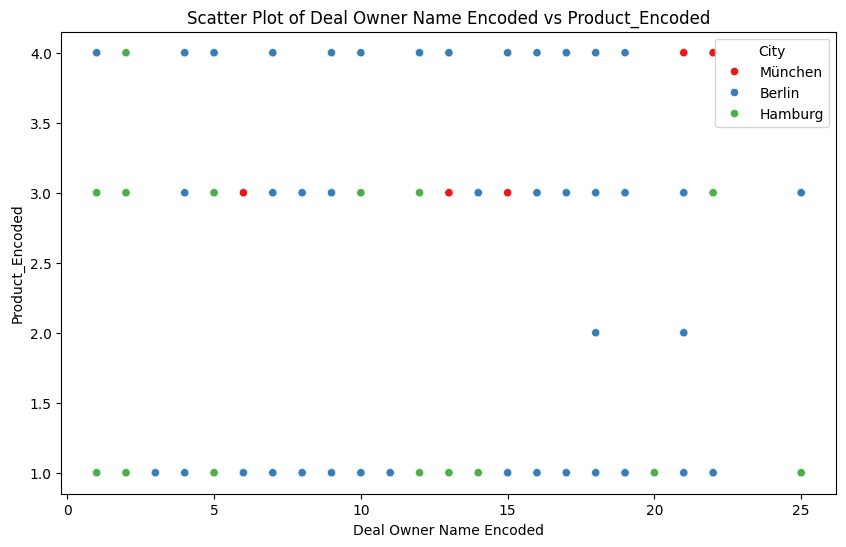

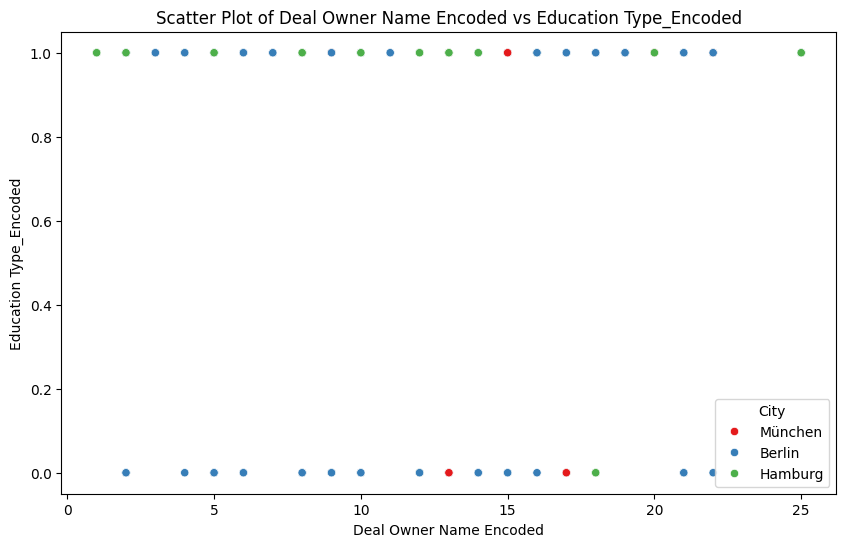

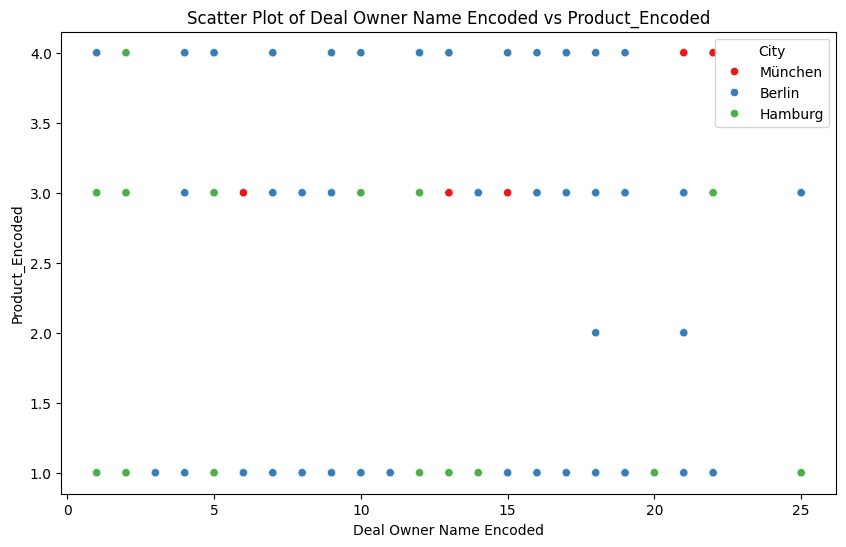

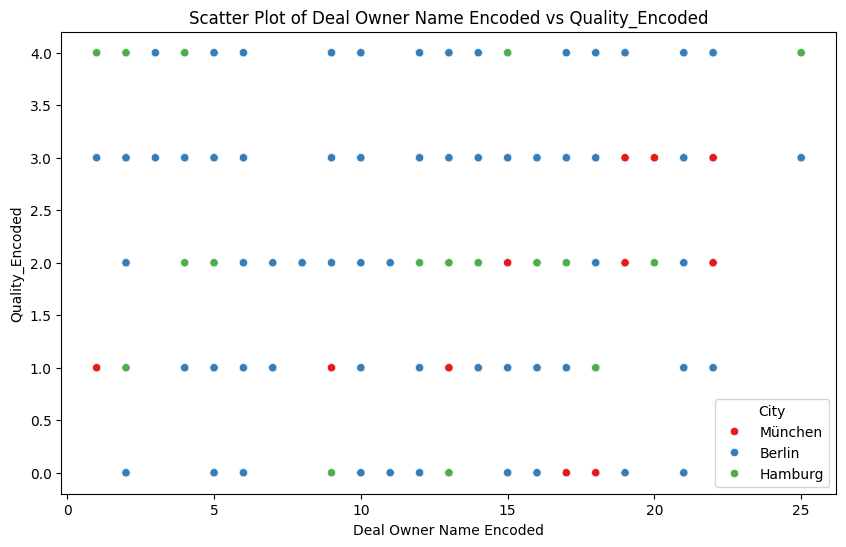

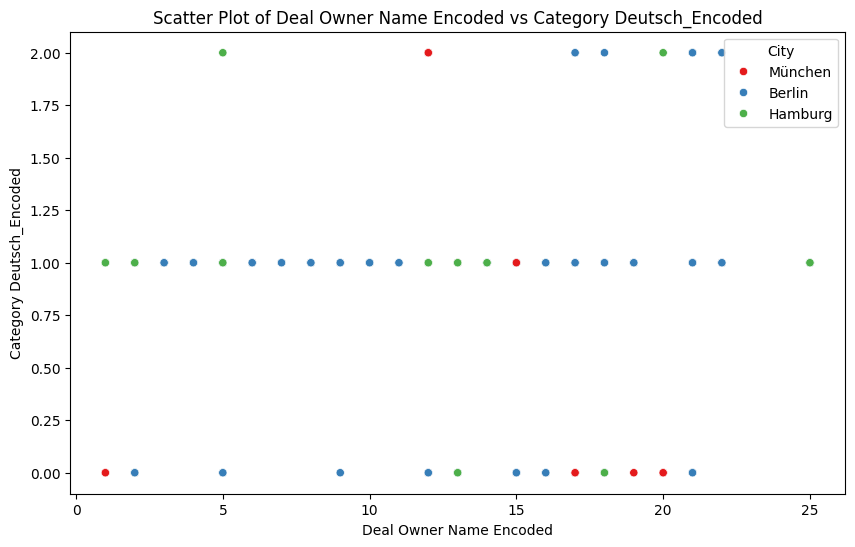

In [25]:
# Отфильтруем данные для Берлин, Мюнхен и Гамбург
filtered_deals_df = deals_df[deals_df['City'].isin(['Berlin', 'München', 'Hamburg'])]

# Пары признаков для построения скаттерплотов
feature_pairs = [
    ('Deal Owner Name Encoded', 'Closing Date'),
    ('Deal Owner Name Encoded', 'Created Time'),
    ('Deal Owner Name Encoded', 'Stage_Encoded'),
    ('Deal Owner Name Encoded', 'Product_Encoded' ),
    ('Deal Owner Name Encoded', 'Education Type_Encoded'),
    ('Deal Owner Name Encoded','Product_Encoded'),
    ('Deal Owner Name Encoded','Quality_Encoded'), 
    ('Deal Owner Name Encoded','Category Deutsch_Encoded')
    
]

# Построение скаттерплотов
for (feature1, feature2) in feature_pairs:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=filtered_deals_df, x=feature1, y=feature2, hue='City', palette='Set1')
    plt.title(f'Scatter Plot of {feature1} vs {feature2}')
    plt.show()

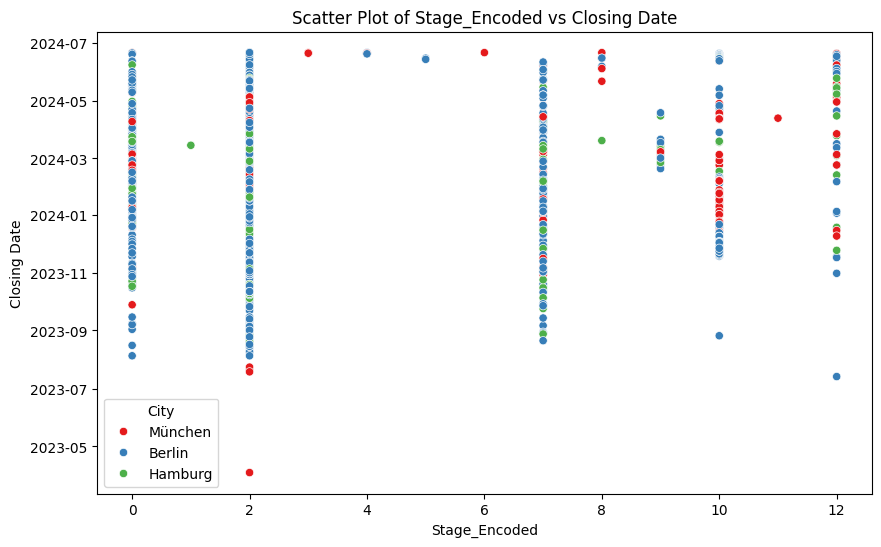

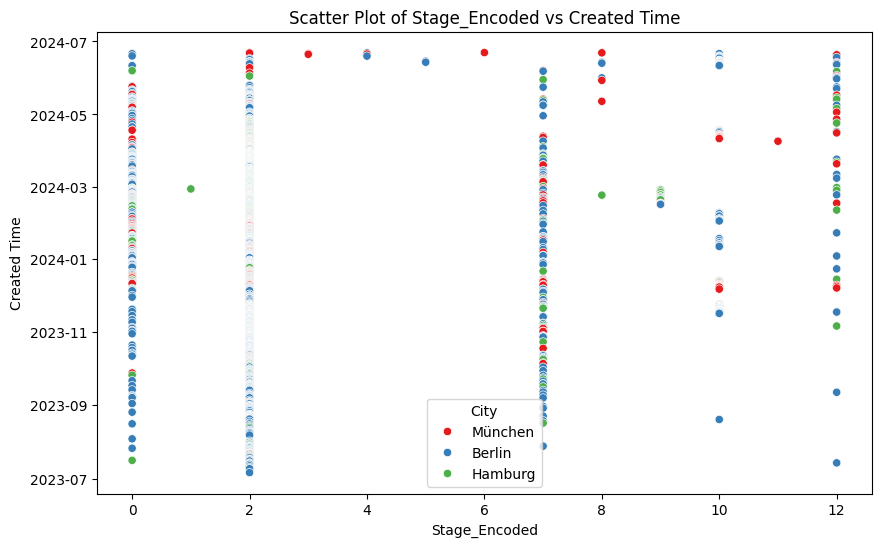

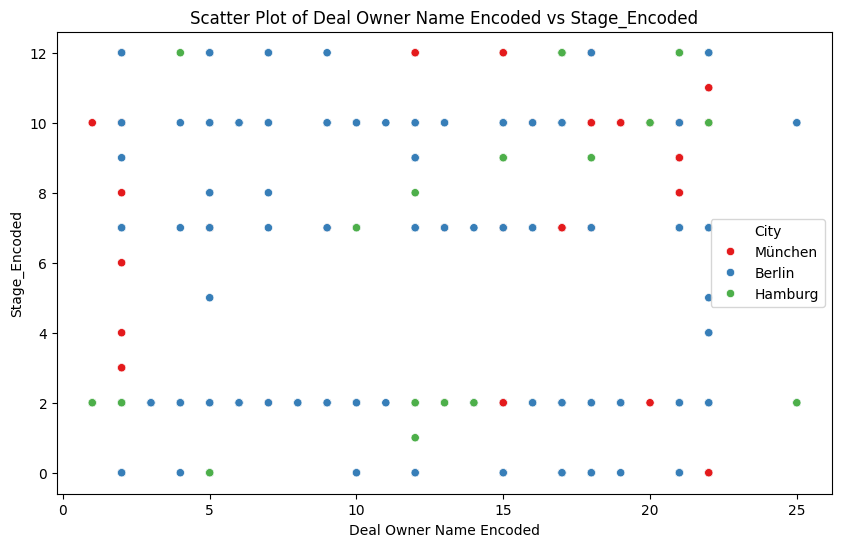

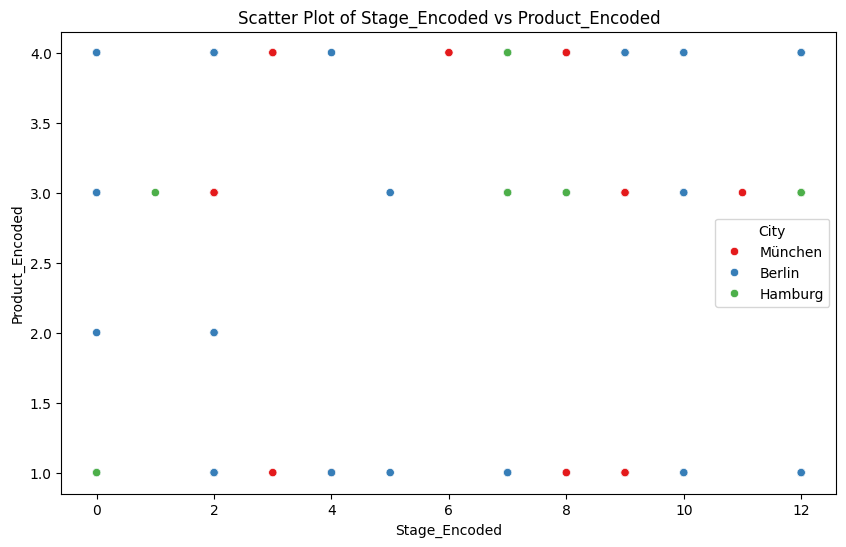

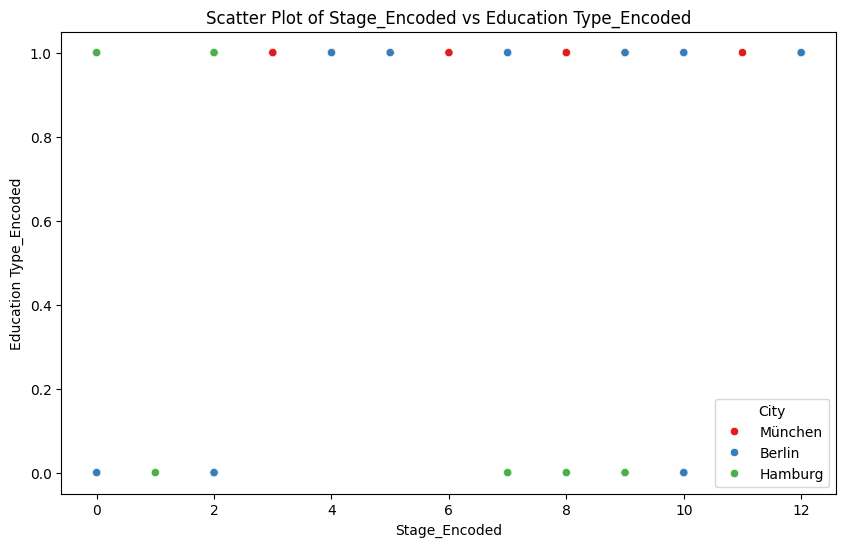

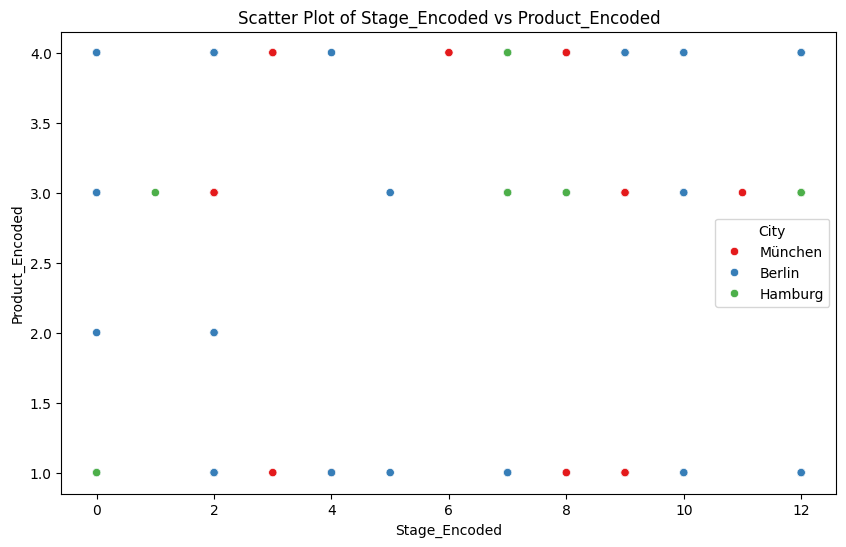

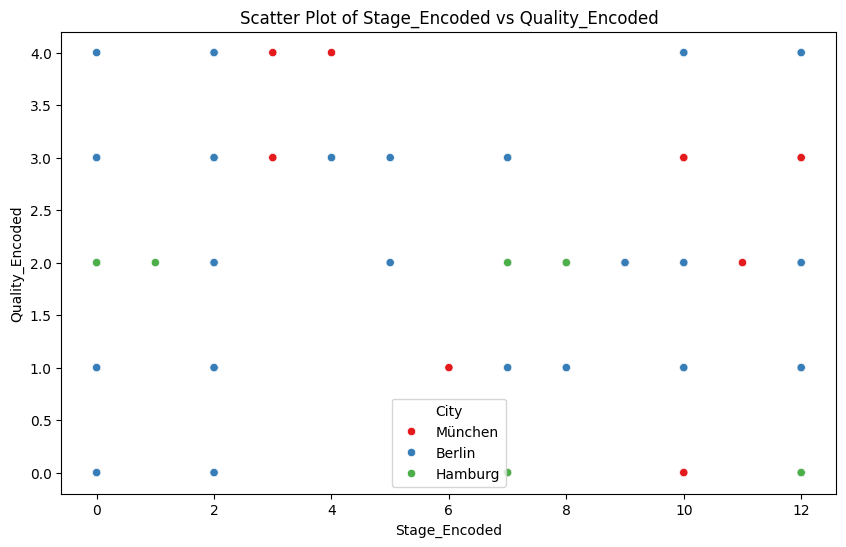

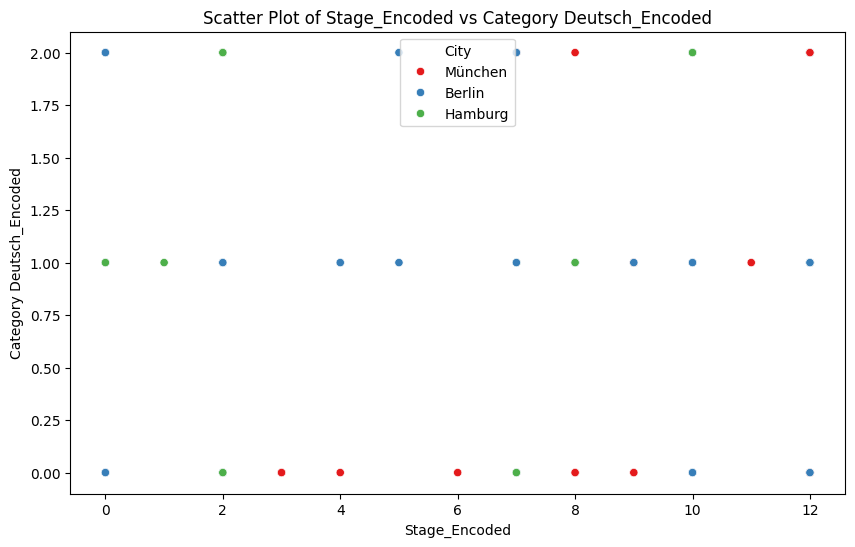

In [26]:
# Отфильтруем данные для Берлин, Мюнхен и Гамбург
filtered_deals_df = deals_df[deals_df['City'].isin(['Berlin', 'München', 'Hamburg'])]

# Пары признаков для построения скаттерплотов
feature_pairs = [
    ('Stage_Encoded', 'Closing Date'),
    ('Stage_Encoded', 'Created Time'),
    ('Deal Owner Name Encoded', 'Stage_Encoded'),
    ('Stage_Encoded', 'Product_Encoded' ),
    ('Stage_Encoded', 'Education Type_Encoded'),
    ('Stage_Encoded','Product_Encoded'),
    ('Stage_Encoded','Quality_Encoded'), 
    ('Stage_Encoded','Category Deutsch_Encoded')
    
]

# Построение скаттерплотов
for (feature1, feature2) in feature_pairs:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=filtered_deals_df, x=feature1, y=feature2, hue='City', palette='Set1')
    plt.title(f'Scatter Plot of {feature1} vs {feature2}')
    plt.show()

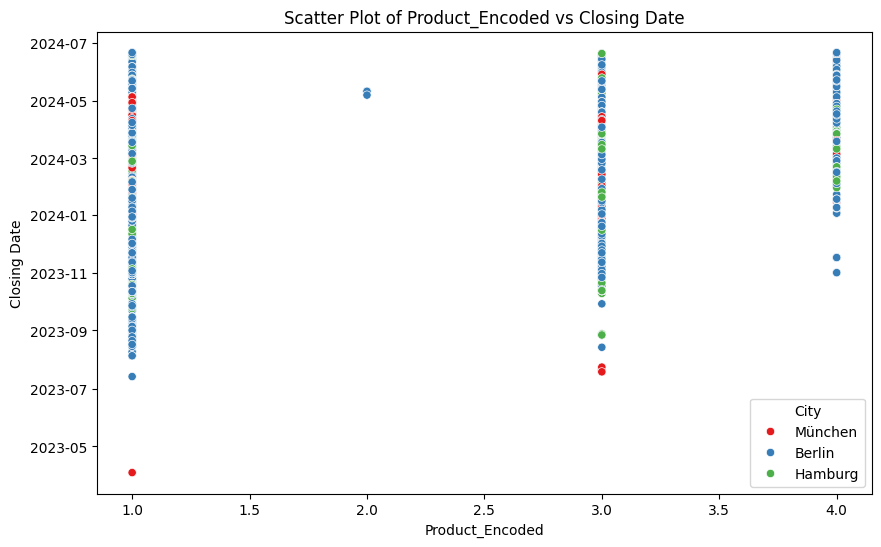

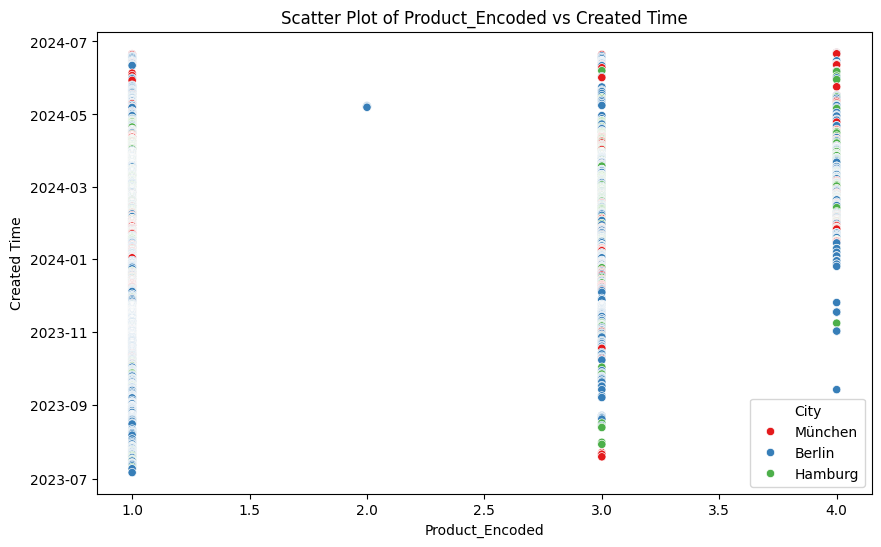

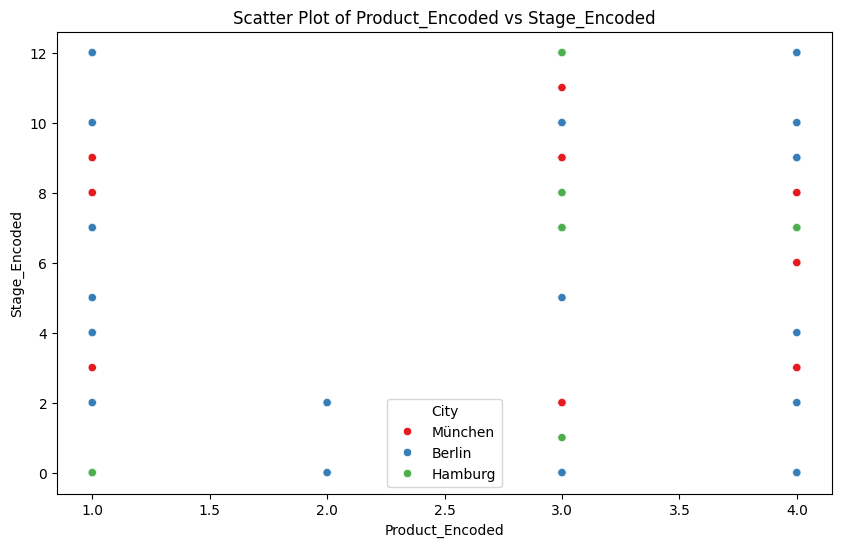

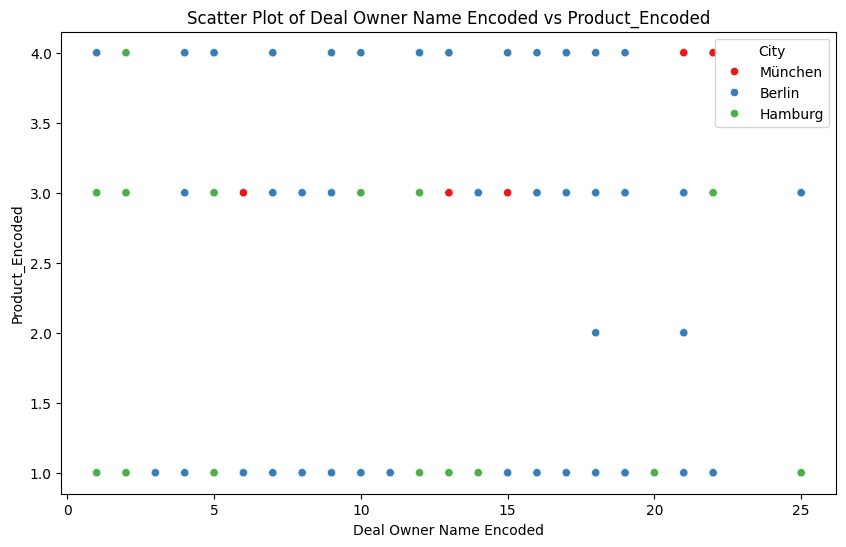

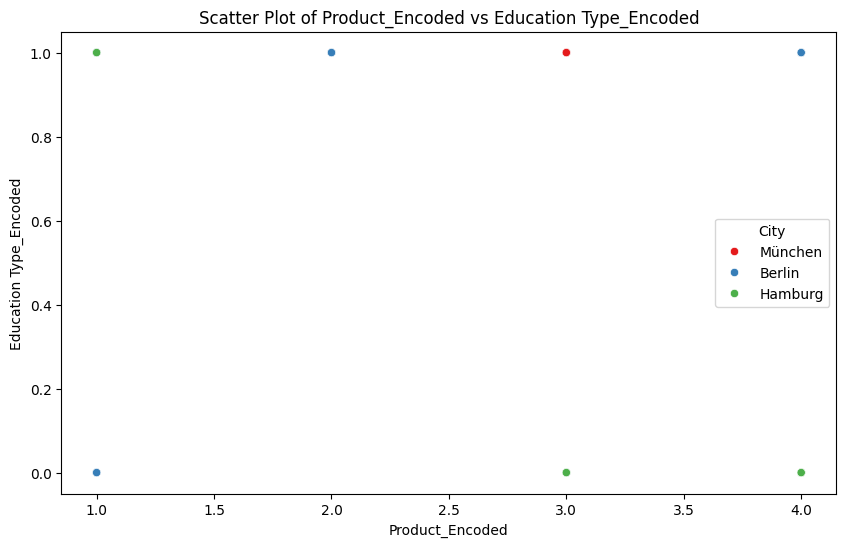

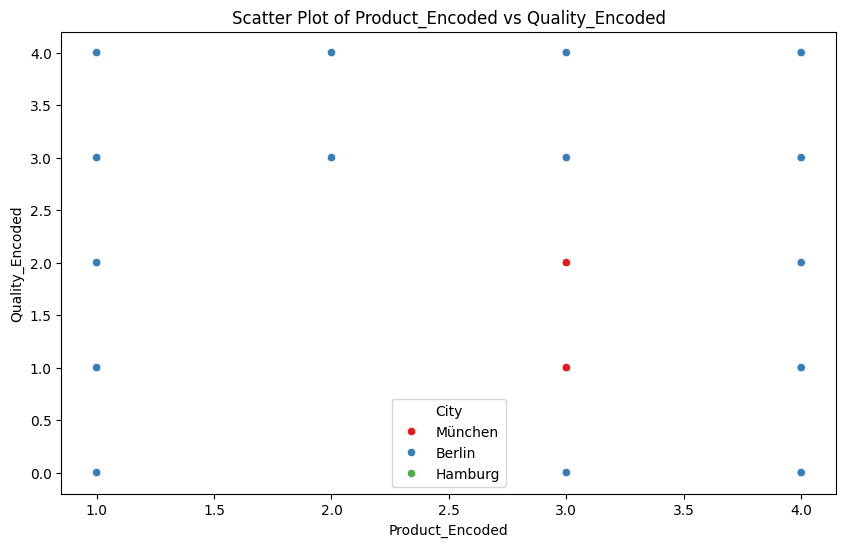

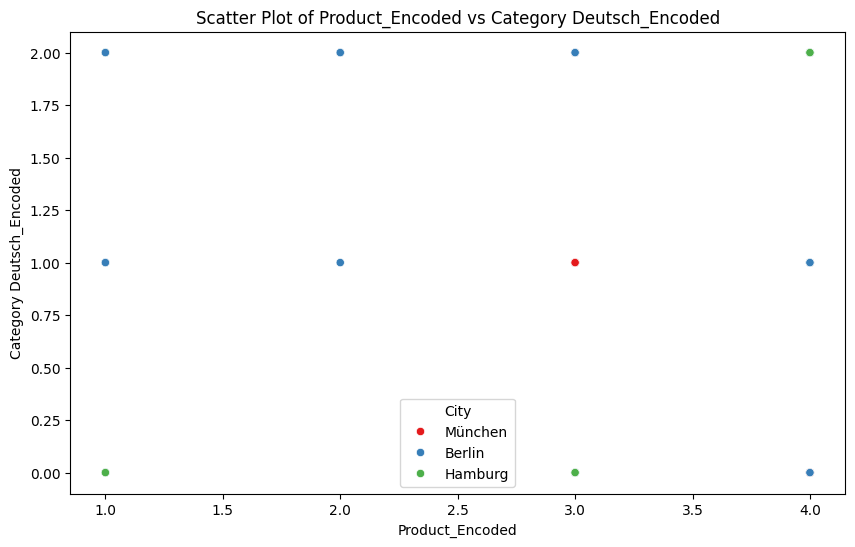

In [28]:
# Отфильтруем данные для Берлин, Мюнхен и Гамбург
filtered_deals_df = deals_df[deals_df['City'].isin(['Berlin', 'München', 'Hamburg'])]

# Пары признаков для построения скаттерплотов
feature_pairs = [
    ('Product_Encoded', 'Closing Date'),
    ('Product_Encoded', 'Created Time'),
    ('Product_Encoded', 'Stage_Encoded'),
    ('Deal Owner Name Encoded', 'Product_Encoded' ),
    ('Product_Encoded', 'Education Type_Encoded'),
    ('Product_Encoded','Quality_Encoded'), 
    ('Product_Encoded','Category Deutsch_Encoded')
    
]

# Построение скаттерплотов
for (feature1, feature2) in feature_pairs:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=filtered_deals_df, x=feature1, y=feature2, hue='City', palette='Set1')
    plt.title(f'Scatter Plot of {feature1} vs {feature2}')
    plt.show()

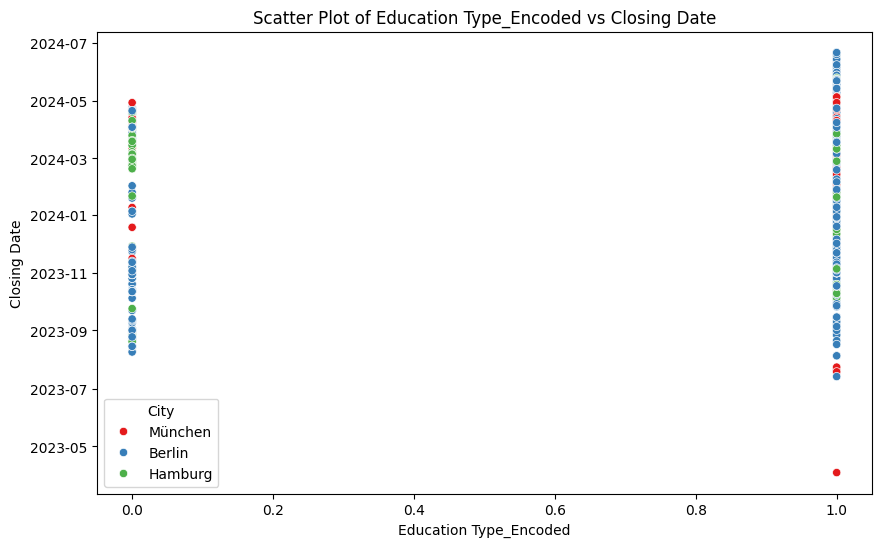

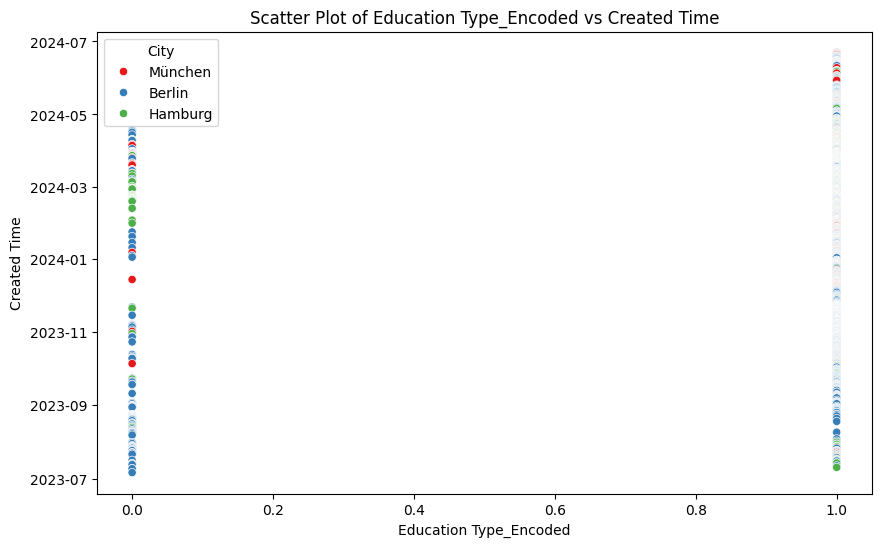

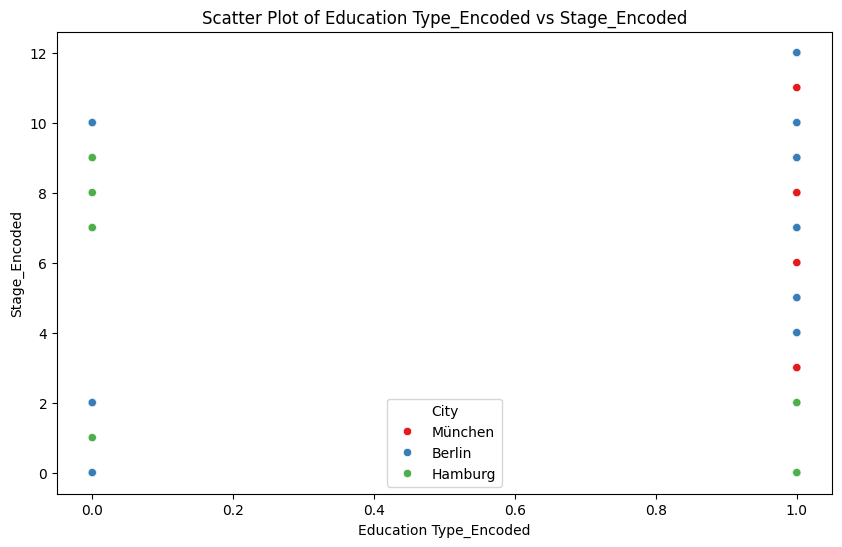

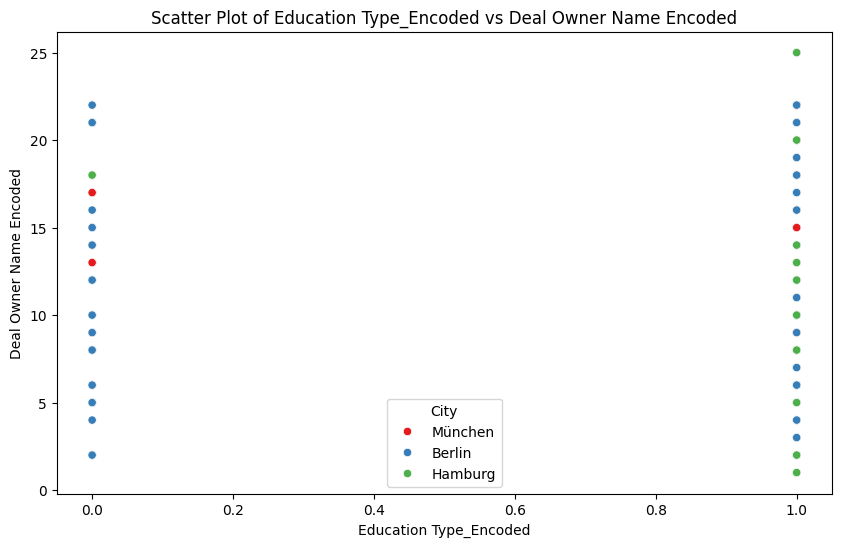

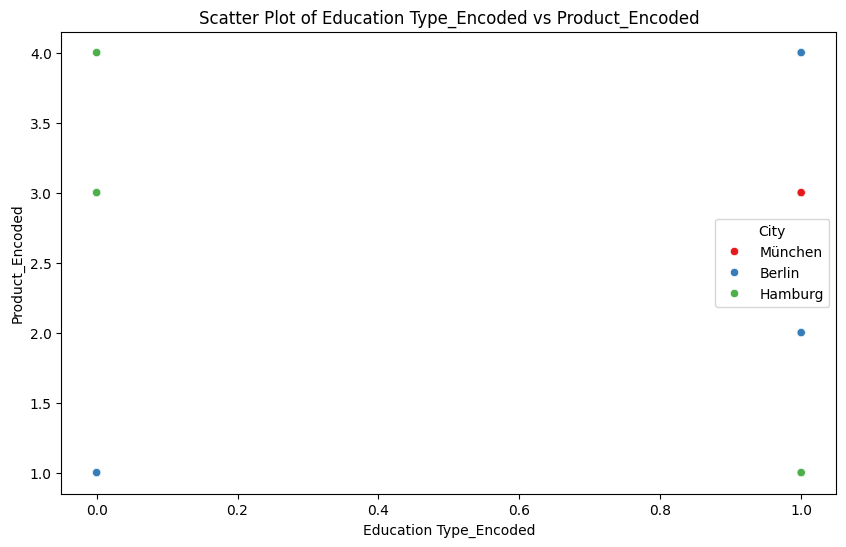

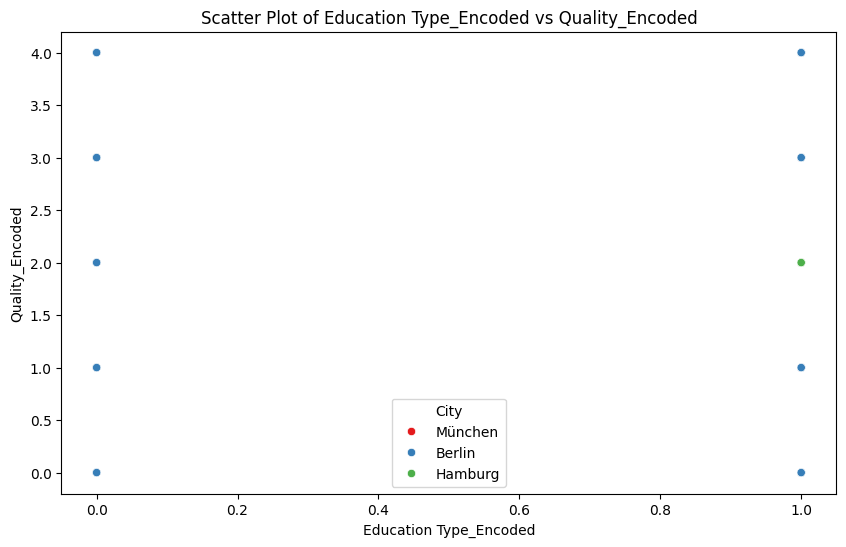

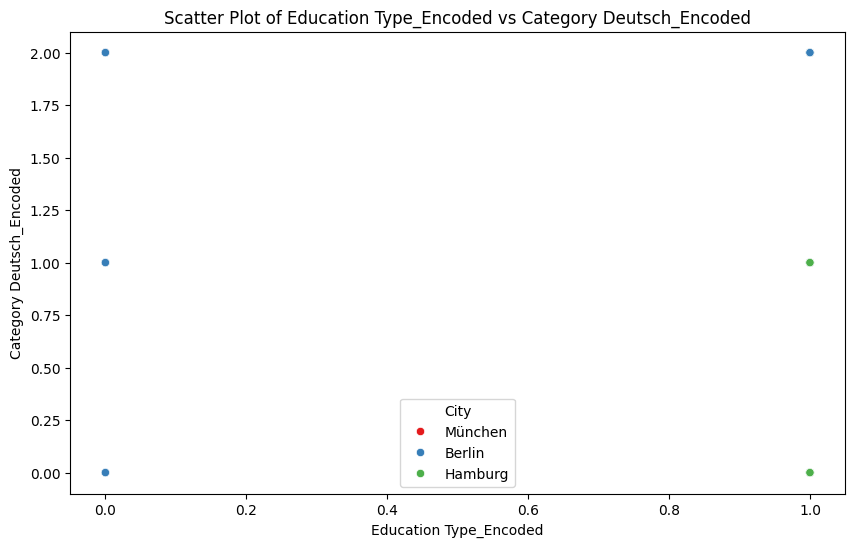

In [29]:
# Отфильтруем данные для Берлин, Мюнхен и Гамбург
filtered_deals_df = deals_df[deals_df['City'].isin(['Berlin', 'München', 'Hamburg'])]

# Пары признаков для построения скаттерплотов
feature_pairs = [
    ('Education Type_Encoded', 'Closing Date'),
    ('Education Type_Encoded', 'Created Time'),
    ('Education Type_Encoded', 'Stage_Encoded'),
    ('Education Type_Encoded','Deal Owner Name Encoded'),
    ('Education Type_Encoded','Product_Encoded'),
    ('Education Type_Encoded','Quality_Encoded'), 
    ('Education Type_Encoded','Category Deutsch_Encoded')
    
]

# Построение скаттерплотов
for (feature1, feature2) in feature_pairs:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=filtered_deals_df, x=feature1, y=feature2, hue='City', palette='Set1')
    plt.title(f'Scatter Plot of {feature1} vs {feature2}')
    plt.show()

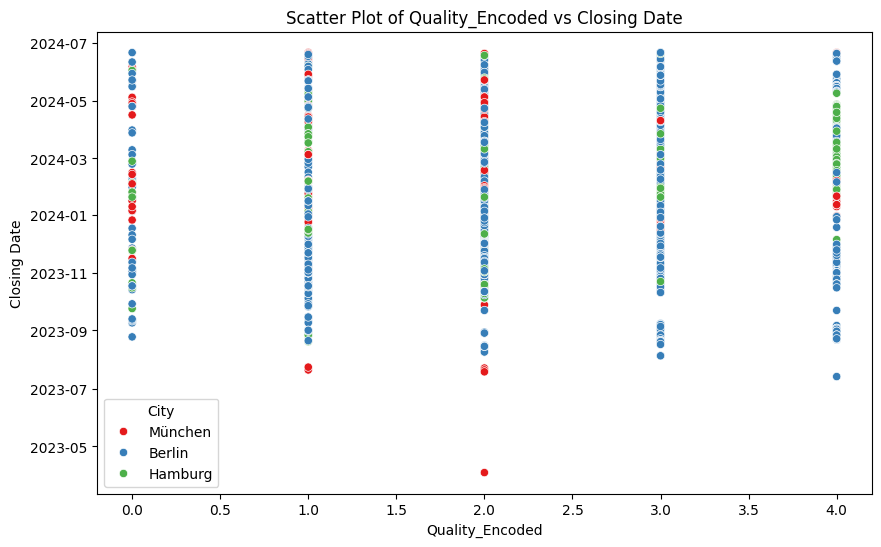

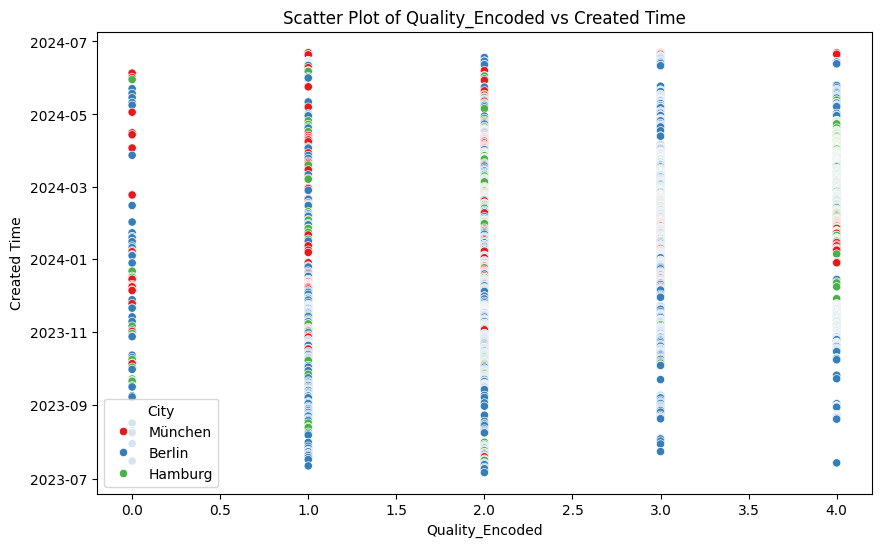

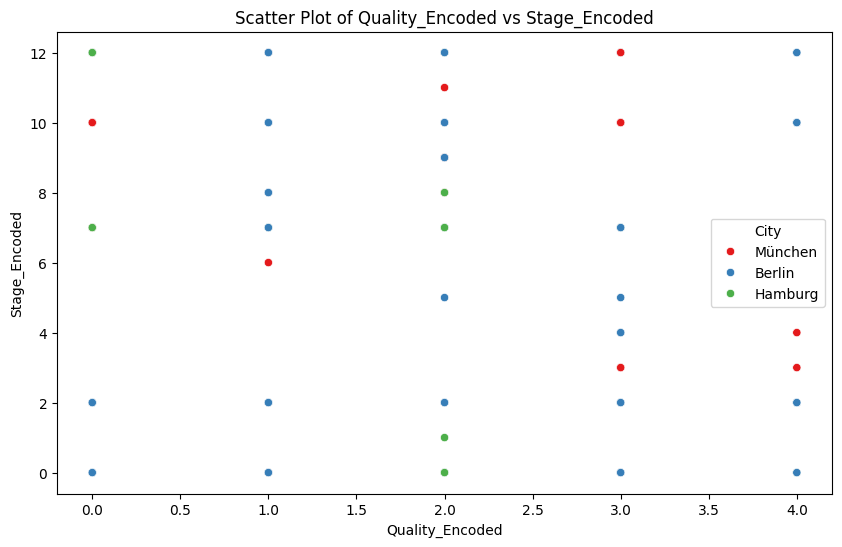

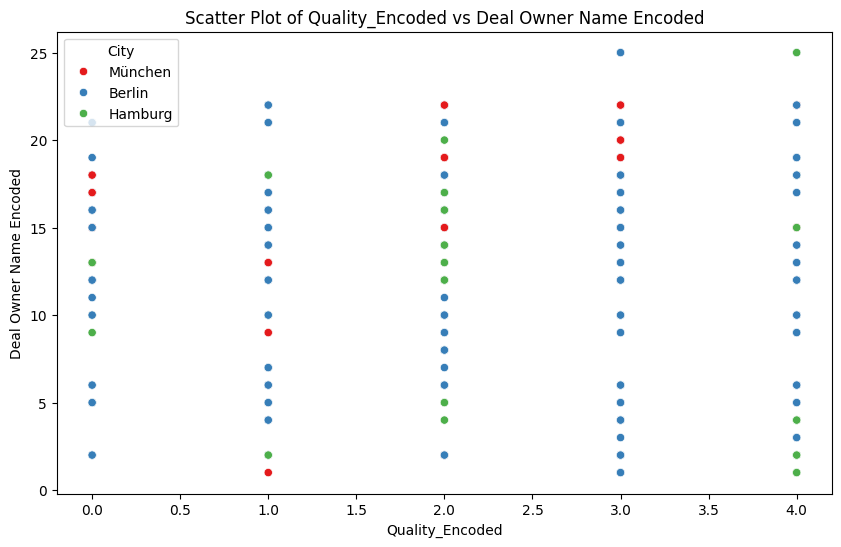

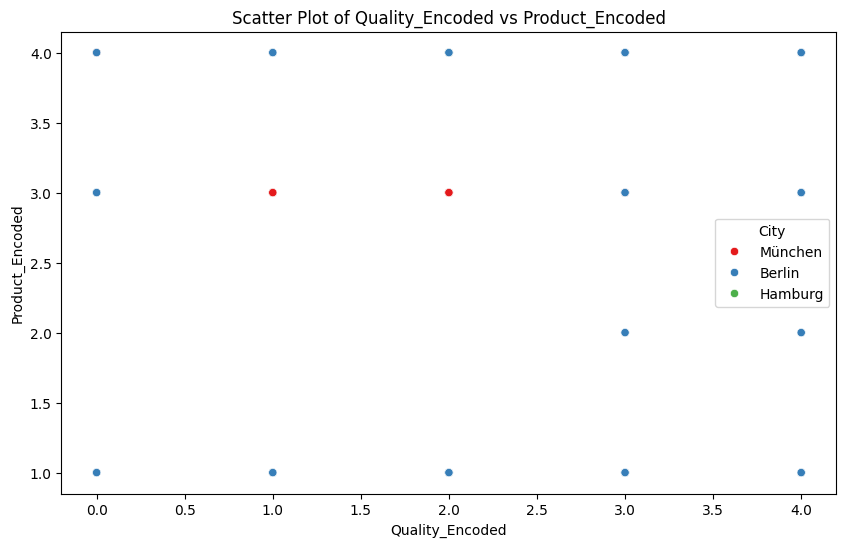

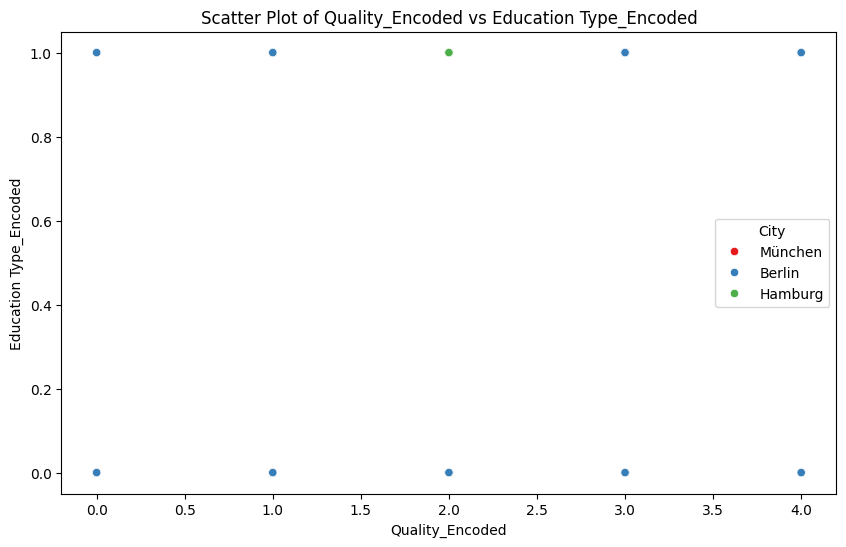

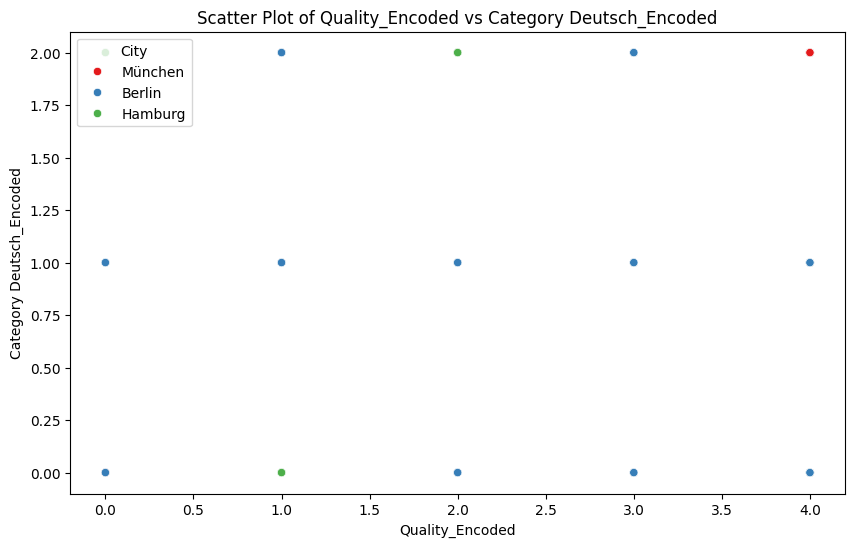

In [30]:
# Отфильтруем данные для Берлин, Мюнхен и Гамбург
filtered_deals_df = deals_df[deals_df['City'].isin(['Berlin', 'München', 'Hamburg'])]

# Пары признаков для построения скаттерплотов
feature_pairs = [
    ('Quality_Encoded', 'Closing Date'),
    ('Quality_Encoded', 'Created Time'),
    ('Quality_Encoded', 'Stage_Encoded'),
    ('Quality_Encoded', 'Deal Owner Name Encoded'),
    ('Quality_Encoded', 'Product_Encoded'),
    ('Quality_Encoded','Education Type_Encoded'), 
    ('Quality_Encoded','Category Deutsch_Encoded')
    
]

# Построение скаттерплотов
for (feature1, feature2) in feature_pairs:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=filtered_deals_df, x=feature1, y=feature2, hue='City', palette='Set1')
    plt.title(f'Scatter Plot of {feature1} vs {feature2}')
    plt.show()

In [16]:
deals_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21502 entries, 0 to 21590
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Id                          21502 non-null  Int64         
 1   Deal Owner Name             21502 non-null  object        
 2   Closing Date                21502 non-null  datetime64[ns]
 3   Quality                     21502 non-null  object        
 4   Stage                       21502 non-null  object        
 5   Lost Reason                 16071 non-null  object        
 6   Page                        21502 non-null  object        
 7   Campaign                    16031 non-null  object        
 8   SLA                         15463 non-null  object        
 9   Ad                          14119 non-null  object        
 10  AdGroup                     12426 non-null  object        
 11  Source                      21502 non-null  object        


In [18]:
deals_df.drop(columns=['Deal Owner Name Encoded', 'Education Type_Encoded', 'Course duration_Encoded', 'Education Type Encoded',
                           'Product_Encoded', 'Category Deutsch_Encoded','Course duration Encoded',
                       'Offer Total Amount_Encoded'], inplace=True)

In [19]:
deals_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21502 entries, 0 to 21590
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Id                  21502 non-null  Int64         
 1   Deal Owner Name     21502 non-null  object        
 2   Closing Date        21502 non-null  datetime64[ns]
 3   Quality             21502 non-null  object        
 4   Stage               21502 non-null  object        
 5   Lost Reason         16071 non-null  object        
 6   Page                21502 non-null  object        
 7   Campaign            16031 non-null  object        
 8   SLA                 15463 non-null  object        
 9   Ad                  14119 non-null  object        
 10  AdGroup             12426 non-null  object        
 11  Source              21502 non-null  object        
 12  Payment Type        21502 non-null  object        
 13  Product             21502 non-null  object        


Среднее (μ) по количеству городов: 2.8612385321100917
Стандартное отклонение (σ) по количеству городов: 13.941661699943312


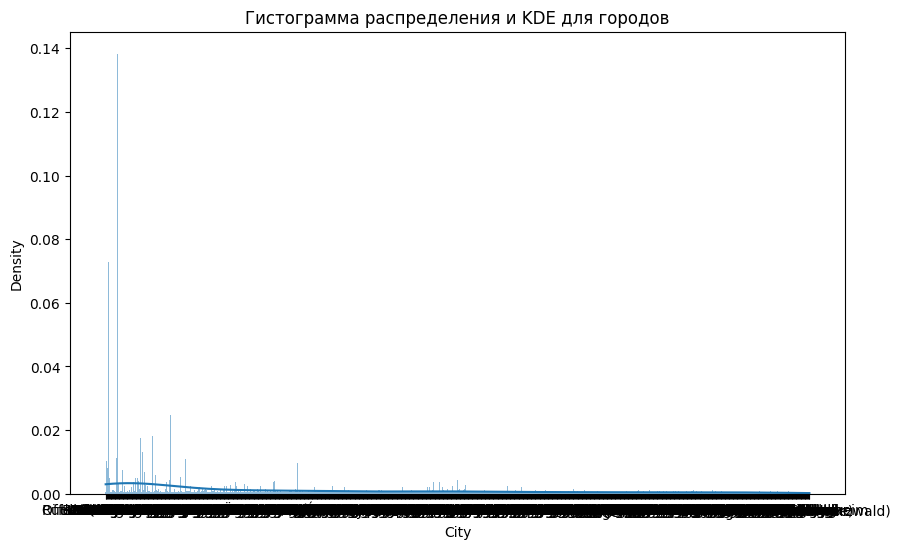

In [22]:
# Фильтрация данных, чтобы рассматривать только строки с заполненными значениями в столбце City
filled_cities = deals_df['City'].dropna()

# Построение гистограммы распределения и KDE
plt.figure(figsize=(10, 6))
sns.histplot(filled_cities, kde=True, stat="density", linewidth=0)
plt.title('Гистограмма распределения и KDE для городов')
plt.xlabel('City')
plt.ylabel('Density')

# Вывод значений среднего и стандартного отклонения
print(f"Среднее (μ) по количеству городов: {filled_cities.value_counts().mean()}")
print(f"Стандартное отклонение (σ) по количеству городов: {filled_cities.value_counts().std()}")

# Показать график
plt.show()

In [20]:
# Фильтрация данных, чтобы рассматривать только строки с заполненными значениями в столбце City
filled_cities = deals_df['City'].dropna()

# Подсчет частот значений в столбце City
city_counts = filled_cities.value_counts()

# Преобразование частот в вероятности
city_probs = city_counts / city_counts.sum()

# Получение списка городов без 'nan'
cities = city_counts.index.tolist()

# Заполнение пропущенных значений в столбце City
deals_df['City'] = deals_df['City'].apply(
    lambda x: np.random.choice(cities, p=city_probs) if pd.isna(x) else x
)

# Проверка, что все пропущенные значения заполнены
print(deals_df['City'].isna().sum())

# Просмотр обновленного DataFrame
print(deals_df[['Id', 'Deal Owner Name', 'City', 'Product', 'Education Type', 'Quality', 'Lost Reason']])

0
                        Id Deal Owner Name          City            Product  \
0      5805028000056864695        Ben Hall      Biberach      Web Developer   
1      5805028000056859489   Ulysses Adams    Litzendorf      Web Developer   
2      5805028000056832357   Ulysses Adams    Weingarten      Web Developer   
3      5805028000056824246        Eva Kent       Leipzig      Web Developer   
4      5805028000056873292        Ben Hall        Wetter      Web Developer   
...                    ...             ...           ...                ...   
21586  5805028000000947046   Oliver Taylor     Troisdorf  Digital Marketing   
21587  5805028000000935025    Kevin Parker  Freudenstadt  Digital Marketing   
21588  5805028000000970006      Jane Smith       Veldenz  Digital Marketing   
21589  5805028000000948010      Jane Smith   Ludwigsburg  Digital Marketing   
21590  5805028000000945016      Jane Smith       Koblenz  Digital Marketing   

      Education Type            Quality          

In [35]:
#!!!! не используем пока...

#используем вероятностный подход, основанный на распределении имеющихся данных. 
#заполняем пропуски, выбирая значения случайным образом с вероятностями, пропорциональными их частотам в заполненных данных.

# Фильтрация данных, чтобы рассматривать только строки с заполненными значениями в столбце City
filled_cities = deals_df['City'].dropna()

# Подсчет частот значений в столбце City
city_counts = filled_cities.value_counts()

# Преобразование частот в вероятности
city_probs = city_counts / city_counts.sum()

# Заполнение пропущенных значений в столбце City
deals_df['City'] = deals_df['City'].apply(
    lambda x: np.random.choice(city_counts.index, p=city_probs) if pd.isna(x) else x
)

# Проверка, что все пропущенные значения заполнены
print(deals_df['City'].isna().sum())

# Просмотр обновленного DataFrame
print(deals_df[['Id', 'Deal Owner Name', 'City', 'Product', 'Education Type', 'Quality', 'Lost Reason']])

0
                        Id Deal Owner Name             City  \
0      5805028000056864695        Ben Hall        Helmstedt   
1      5805028000056859489   Ulysses Adams       Waiblingen   
2      5805028000056832357   Ulysses Adams         Leonberg   
3      5805028000056824246        Eva Kent          Leipzig   
4      5805028000056873292        Ben Hall  Friedrichshafen   
...                    ...             ...              ...   
21586  5805028000000947046   Oliver Taylor         Naumburg   
21587  5805028000000935025    Kevin Parker        Pforzheim   
21588  5805028000000970006      Jane Smith          Hamburg   
21589  5805028000000948010      Jane Smith           Hameln   
21590  5805028000000945016      Jane Smith     Freudenstadt   

                 Product Education Type            Quality  \
0          Web Developer        Morning  E - Non Qualified   
1          Web Developer        Morning  E - Non Qualified   
2          Web Developer        Morning     D - Non Tar

In [23]:
deals_df.City.nunique()

871

In [21]:
deals_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21502 entries, 0 to 21590
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Id                  21502 non-null  Int64         
 1   Deal Owner Name     21502 non-null  object        
 2   Closing Date        21502 non-null  datetime64[ns]
 3   Quality             21502 non-null  object        
 4   Stage               21502 non-null  object        
 5   Lost Reason         16071 non-null  object        
 6   Page                21502 non-null  object        
 7   Campaign            16031 non-null  object        
 8   SLA                 15463 non-null  object        
 9   Ad                  14119 non-null  object        
 10  AdGroup             12426 non-null  object        
 11  Source              21502 non-null  object        
 12  Payment Type        21502 non-null  object        
 13  Product             21502 non-null  object        


In [24]:
deals_df.City.unique()

array(['Biberach', 'Litzendorf', 'Weingarten', 'Leipzig', 'Wetter',
       'Delitzsch', 'Moscow', 'Schwäbisch Hall', 'Meerbusch', 'Nürnberg',
       'Berlin', 'Hamburg', 'Pforzheim', 'Wuppertal',
       'Bad Friedrichshall', 'Aschaffenburg', 'Mönchengladbach',
       'Gommern', 'Kaiserslautern', 'Pirmasens', 'Herdecke', 'Bremen',
       'Mahlberg', 'Jünkerath', 'Weiden', 'Hildesheim', 'Radebeul',
       'Zorneding', 'Nastätten', 'Hameln', 'Hilchenbach',
       'Villingen-Schwenningen', 'Düsseldorf', 'Potsdam', 'Teterow',
       'Bad Gandersheim', 'Bad Hindelang', 'Olpe', 'Arnsberg',
       'Lutherstadt Wittenberg', 'Przesław', 'Oldenburg', 'Köln',
       'Holzwickede', 'Ahrensburg', 'Crailsheim', 'Itzehoe', 'Gera',
       'Dortmund', 'Würzburg', 'Taraz', 'Sindelfingen', 'Magdeburg',
       'Stuttgart', 'Warendorf', 'Chemnitz', 'Gelnhausen', 'Kerpen',
       'Bochum', 'München', 'Triberg', 'Dresden', 'Kassel', 'Alsfeld',
       'Güglingen', 'Wangen im Allgäu', 'Wandlitz', 'Fürstenfeldbr

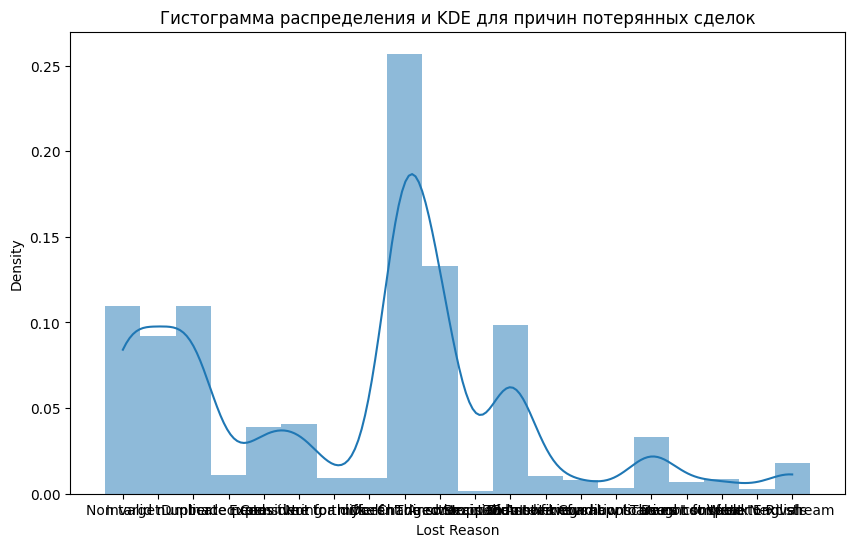

Среднее (μ) по Lost Reason: 0.05
Стандартное отклонение (σ) по Lost Reason: 0.06527562076653251
0
                        Id Deal Owner Name          City            Product  \
0      5805028000056864695        Ben Hall      Biberach      Web Developer   
1      5805028000056859489   Ulysses Adams    Litzendorf      Web Developer   
2      5805028000056832357   Ulysses Adams    Weingarten      Web Developer   
3      5805028000056824246        Eva Kent       Leipzig      Web Developer   
4      5805028000056873292        Ben Hall        Wetter      Web Developer   
...                    ...             ...           ...                ...   
21586  5805028000000947046   Oliver Taylor     Troisdorf  Digital Marketing   
21587  5805028000000935025    Kevin Parker  Freudenstadt  Digital Marketing   
21588  5805028000000970006      Jane Smith       Veldenz  Digital Marketing   
21589  5805028000000948010      Jane Smith   Ludwigsburg  Digital Marketing   
21590  5805028000000945016      J

In [25]:
#Заполнение пропущенных значений в столбце Lost Reason с использованием вероятностного подхода 

# Фильтрация данных, чтобы рассматривать только строки с заполненными значениями в столбце Lost Reason
filled_lost_reasons = deals_df['Lost Reason'].dropna()

# Построение гистограммы распределения и KDE
plt.figure(figsize=(10, 6))
sns.histplot(filled_lost_reasons, kde=True, stat="density", linewidth=0)
plt.title('Гистограмма распределения и KDE для причин потерянных сделок')
plt.xlabel('Lost Reason')
plt.ylabel('Density')

# Определение среднего (μ) и стандартного отклонения (σ)
lost_reason_counts = filled_lost_reasons.value_counts()
lost_reason_probs = lost_reason_counts / lost_reason_counts.sum()
mean_lost_reason = lost_reason_probs.mean()
std_lost_reason = lost_reason_probs.std()

# Показать график
plt.show()

# Вывод значений среднего и стандартного отклонения
print(f"Среднее (μ) по Lost Reason: {mean_lost_reason}")
print(f"Стандартное отклонение (σ) по Lost Reason: {std_lost_reason}")

# Заполнение пропущенных значений в столбце Lost Reason
deals_df['Lost Reason'] = deals_df['Lost Reason'].apply(
    lambda x: np.random.choice(lost_reason_counts.index, p=lost_reason_probs) if pd.isna(x) else x
)

# Проверка, что все пропущенные значения заполнены
print(deals_df['Lost Reason'].isna().sum())

# Просмотр обновленного DataFrame
print(deals_df[['Id', 'Deal Owner Name', 'City', 'Product', 'Education Type', 'Quality', 'Lost Reason']])

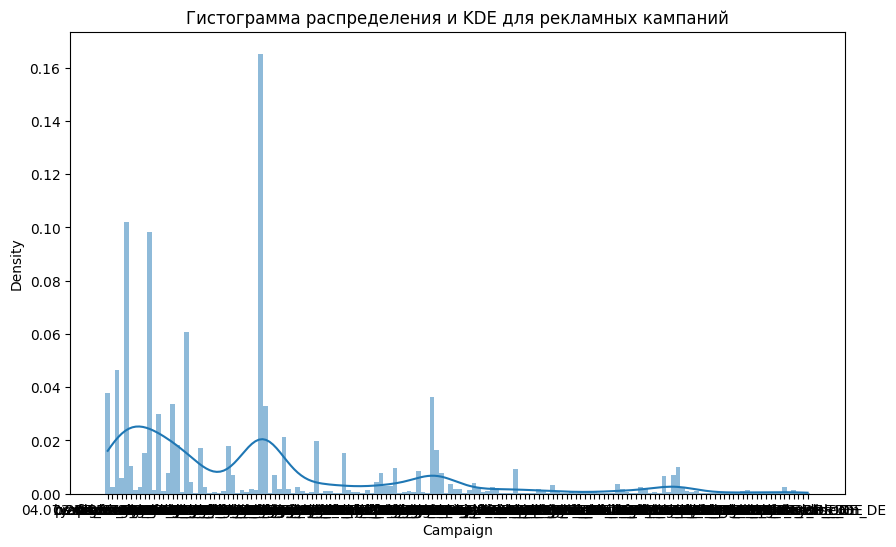

Среднее (μ) по Campaign: 0.006578947368421052
Стандартное отклонение (σ) по Campaign: 0.019265818341863014
0
                        Id Deal Owner Name          City            Product  \
0      5805028000056864695        Ben Hall      Biberach      Web Developer   
1      5805028000056859489   Ulysses Adams    Litzendorf      Web Developer   
2      5805028000056832357   Ulysses Adams    Weingarten      Web Developer   
3      5805028000056824246        Eva Kent       Leipzig      Web Developer   
4      5805028000056873292        Ben Hall        Wetter      Web Developer   
...                    ...             ...           ...                ...   
21586  5805028000000947046   Oliver Taylor     Troisdorf  Digital Marketing   
21587  5805028000000935025    Kevin Parker  Freudenstadt  Digital Marketing   
21588  5805028000000970006      Jane Smith       Veldenz  Digital Marketing   
21589  5805028000000948010      Jane Smith   Ludwigsburg  Digital Marketing   
21590  580502800000094

In [26]:
# Фильтрация данных, чтобы рассматривать только строки с заполненными значениями в столбце Campaign
filled_campaigns = deals_df['Campaign'].dropna()

# Построение гистограммы распределения и KDE
plt.figure(figsize=(10, 6))
sns.histplot(filled_campaigns, kde=True, stat="density", linewidth=0)
plt.title('Гистограмма распределения и KDE для рекламных кампаний')
plt.xlabel('Campaign')
plt.ylabel('Density')

# Определение среднего (μ) и стандартного отклонения (σ)
campaign_counts = filled_campaigns.value_counts()
campaign_probs = campaign_counts / campaign_counts.sum()
mean_campaign = campaign_probs.mean()
std_campaign = campaign_probs.std()

# Показать график
plt.show()

# Вывод значений среднего и стандартного отклонения
print(f"Среднее (μ) по Campaign: {mean_campaign}")
print(f"Стандартное отклонение (σ) по Campaign: {std_campaign}")

# Заполнение пропущенных значений в столбце Campaign
deals_df['Campaign'] = deals_df['Campaign'].apply(
    lambda x: np.random.choice(campaign_counts.index, p=campaign_probs) if pd.isna(x) else x
)

# Проверка, что все пропущенные значения заполнены
print(deals_df['Campaign'].isna().sum())

# Просмотр обновленного DataFrame
print(deals_df[['Id', 'Deal Owner Name', 'City', 'Product', 'Education Type', 'Quality', 'Campaign']])

In [28]:
# Сохранение датафрейма в Excel файл
output_file_path = 'update_deals.xlsx'
deals_df.to_excel(output_file_path, index=False)

print(f"Датафрейм успешно сохранен в файл {output_file_path}")

Датафрейм успешно сохранен в файл update_deals.xlsx


In [29]:
deals_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21502 entries, 0 to 21590
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Id                  21502 non-null  Int64         
 1   Deal Owner Name     21502 non-null  object        
 2   Closing Date        21502 non-null  datetime64[ns]
 3   Quality             21502 non-null  object        
 4   Stage               21502 non-null  object        
 5   Lost Reason         21502 non-null  object        
 6   Page                21502 non-null  object        
 7   Campaign            21502 non-null  object        
 8   SLA                 15463 non-null  object        
 9   Ad                  14119 non-null  object        
 10  AdGroup             12426 non-null  object        
 11  Source              21502 non-null  object        
 12  Payment Type        21502 non-null  object        
 13  Product             21502 non-null  object        


In [41]:
# Сохранение датафрейма в файл .pkl для удобной загрузки в Jupyter Notebook
deals_df.to_pickle('update_deals.pkl')


Процент пропущенных значений по каждому столбцу:
Id                     0.000000
Deal Owner Name        0.000000
Closing Date           0.000000
Quality                0.000000
Stage                  0.000000
Lost Reason            0.000000
Page                   0.000000
Campaign               0.000000
SLA                   28.085759
Ad                    34.336341
AdGroup               42.210027
Source                 0.000000
Payment Type           0.000000
Product                0.000000
Education Type         0.000000
Created Time           0.000000
Course duration        0.000000
Months of study       96.130593
Offer Total Amount     0.000000
CONTACTID              0.000000
City                   0.000000
Category Deutsch       0.000000
dtype: float64


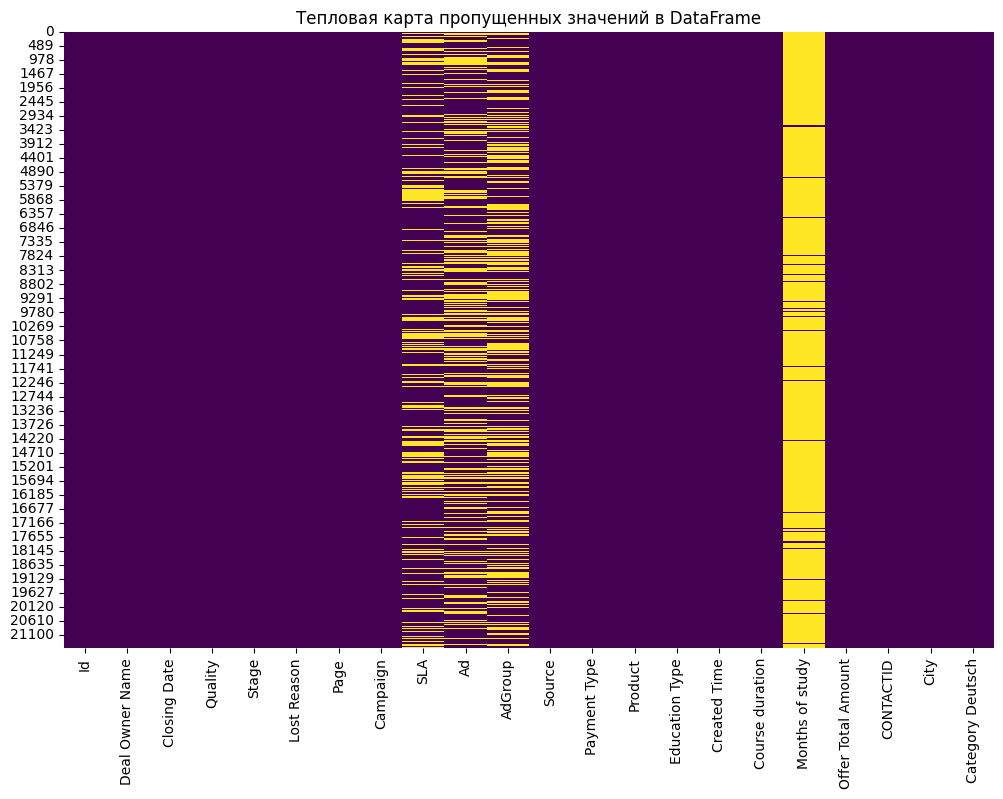

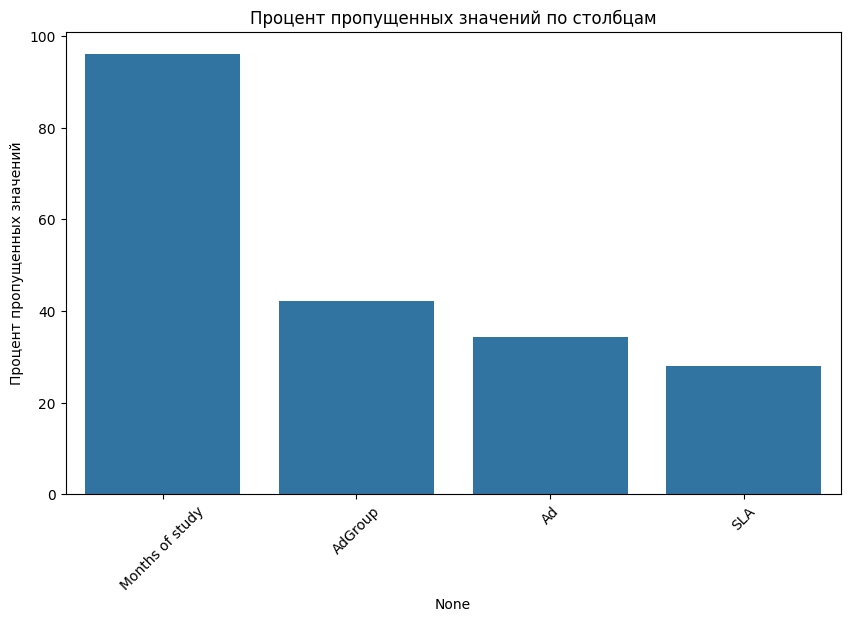

In [30]:
# Отображение пропущенных значений в процентах для каждого столбца
missing_data = deals_df.isnull().mean() * 100
print("Процент пропущенных значений по каждому столбцу:")
print(missing_data)

# Визуализация пропущенных данных с использованием тепловой карты (heatmap)
plt.figure(figsize=(12, 8))
sns.heatmap(deals_df.isnull(), cbar=False, cmap='viridis')
plt.title('Тепловая карта пропущенных значений в DataFrame')
plt.show()

# Гистограмма пропущенных данных по столбцам
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_data.index, y=missing_data)
plt.title('Процент пропущенных значений по столбцам')
plt.ylabel('Процент пропущенных значений')
plt.xticks(rotation=45)
plt.show()